# COVID-19: ANALISI CON MODELLI SIR E SEIR

# Authors:
Danilo Giovannico

Andrea Gatto

In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from scipy.integrate import odeint
import math


# #UPLOAD DATASET

In [2]:
start_date = '1/22/20'
days_interval = 150
country = 'Italy'

df_confirmed = pd.read_csv('data/time_series_19-covid-Confirmed-country.csv')
country_df_confirmed = df_confirmed[df_confirmed['Country/Region'] == country]

df_recovered = pd.read_csv('data/time_series_19-covid-Recovered-country.csv')
country_df_recovered = df_recovered[df_recovered['Country/Region'] == country]

df_deaths = pd.read_csv('data/time_series_19-covid-Deaths-country.csv')
country_df_deaths = df_deaths[df_deaths['Country/Region'] == country]


# #SIR MODEL (Italy Dataset) with Optimization
Il modello SIR è una sorta di modello compartimentale che descrive la dinamica della malattia infettiva (I modelli compartimentali sono una tecnica utilizzata per semplificare la modellizzazione matematica delle malattie infettive). Il modello divide la popolazione in compartimenti. I tre compartimenti sono i seguenti: persone vulnerabili all'esposizione con le persone infette, persone infette che possono trasmettere il virus e persone guarite che hanno ottenuto l'immunità. 
![](../data/SIR-Diagram.png)
Il modello SIR ci consente di descrivere il numero di persone in ogni compartimento tramite equazione differenziale ordinaria. β è un parametro che controlla quanto la malattia può essere trasmessa attraverso l'esposizione. È determinato dalla possibilità di contatto e dalla probabilità di trasmissione della malattia. γ è un parametro che esprime quanto la malattia può essere recuperata in un periodo specifico. Una volta che le persone sono guarite, ottengono l'immunità. Non c'è alcuna possibilità che tornino ad essere infette. 
<div style="text-align: center"><img src="../data/SIR-Equation.png" alt="Drawing" style="width: 200px;"/></div>
Nel modello non consideriamo l'effetto della morte naturale o del tasso di natalità perché il modello presuppone che il periodo della malattia sia molto più breve della vita umana. 
Da tali valori possiamo ottenere importanti osservazioni:
$$ D = \frac{1}{\gamma } $$
D è il numero di giorni per riprendersi dalla malattia
$$ R_{0} = \frac{\beta }{\gamma } $$
R0 è il mumero medio di persone infette da un'altra persona; più alto è più la pandemia si sviluppa. Il numero viene anche utilizzato per stimare la soglia immunitaria della mandria (HIT). Se il numero di riproduzione di base R0 moltiplicato per la percentuale di persone non immuni (sensibili) è uguale a 1, indica lo stato equilibrato. Il numero di persone infette è costante. Supponiamo che la percentuale di persone immuni sia p, lo stato stabile può essere formulato come segue:
$$ R_{0}(1-p) = 1 \rightarrow 1 - p = \frac{1}{R_{0}} \rightarrow p_{c} = 1 - \frac{1}{R_{0}} $$
Perciò, pc è l'HIT per fermare la diffusione della malattia infettiva. Possiamo fermare l'epidemia vaccinando la popolazione per aumentare l'immunità della mandria.

Quello che faremo è stimare il β e γ per adattarli al modello SIR con i casi confermati effettivi (il numero di persone infette). Per risolvere la normale equazione differenziale come il modello SIR, possiamo usare la funzione solving_ivp nel modulo scipy.

### Definizione della funzione per il modello

In [3]:
def SIR(t, y, beta, gamma):
    #print(y)
    # t indici corrispondenti ai giorni
    #y è un array con tre sotto array contenti i pesi relativi a: suscettibili, infetti e guariti
    S = y[0]
    I = y[1]
    R = y[2]
    #ritorno i valori delle 3 equazioni differenziali calcolati
    return [-beta*S*I, beta*S*I-gamma*I, gamma*I]


### Definizione della funzione loss per l'ottimizzazione dei parametri

La funzione loss passata alla funzione minimize è usata per trovare i migliori parametri beta e gamma sul modello utilizzando lo score del modello ad ogni iterazione. I pesi vengono aggiornati fino a convergenza dei valori.

In [4]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    # Questa funzione integra numericamente un sistema di equazioni differenziali ordinarie dato un valore iniziale. I parametri accettati
    # sono: la funzione da integrare, l'intervallo di integrazione [0, size], lo stato iniziale [s_0,i_0,r_0], 
    # t_eval = i tempi in cui conservare la soluzione calcolata devono essere ordinati e devono trovarsi all'interno di t_span,
    # Vectorized per integrare usando vettori.
    solution = solve_ivp(lambda t, y: SIR(t, y, beta, gamma), [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    # Utilizzo come funzione di perdita per il processo di ottimizzazione l'errore quadratico medio di radice (RMSE),
    # questa viene valutata sia sul dataframe data che su quello recovered. Le stime vanno sottratte ai dati reali per poi applicare
    # RMSE, infine si congiungono gli score per avere una misura dell'errore sul modello.
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    #print(alpha * l1 + (1 - alpha) * l2)
    return alpha * l1 + (1 - alpha) * l2

### Funzione per estendere i valori temporali per previsioni future

La funzione extend index permette di estendere il range di previsione sui dati nei giorni successivi all'ultima data utile del dataset. Essa aggiunge 1 giorno fino alla nuova dimensione scelta. Index sono la lista di date presenti per i dati del dataset.

In [5]:
def extend_index(index, new_size):
    values = index.values
    current = datetime.strptime(index[-1], '%m/%d/%y')
    while len(values) < new_size:
        current = current + timedelta(days=1)
        values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
    # ritorno la nuova lista di date estesa fino al nuovo range scelto
    return values


### Funzione per eseguire la predizione dei valori richiamando il modello SIR

Funzione di predizione del modello SIR, la quale estende l'intervallo di analisi per lo sviluppo pandemico.

In [6]:
def predict(beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
    # Eseguo la funzione extend index su data.index, che contiene le date per i dati estratti dal dataset; inoltre passo il range di estensione
    # per avere una previsione nell'arco di data.index fino a 150 giorni
    new_index = extend_index(data.index, days_interval)
    size = len(new_index)

    #Estendo i dataframe eseguendo la concatenazione per i suscettibili, infetti e morti estendendolo fino al nuovo range scelto; 
    #inserisco None per i giorni che mancano dall'estensione ai dati reali
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
    # Nel ritorno dati eseguo l'integrazione per avere i valori predetti dal SIR con i valori ottimali trovati grazie alla funzione loss e l'RSME.
    return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(lambda t, y: SIR(t, y, beta, gamma), [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

### Plotting del modello

Esecuzione del notebook con plot del modello predetto e dei valori veri.

In [7]:
s_0 = 180000
i_0 = 14
r_0 = 1

recovered = country_df_recovered.iloc[0].loc[start_date:]
death = country_df_deaths.iloc[0].loc[start_date:]
data = (country_df_confirmed.iloc[0].loc[start_date:] - recovered - death)

# Minimize riduce al minimo una funzione scalare di una o più variabili usando l'algoritmo L-BFGS-B. Gli argomenti da passare sono: la funzione 
# scalare di più variabili loss con gli argomenti passati args, i valori di partenza iniziali [0.001, 0.001], l'algoritmo L-BFGS-B,
# limiti alle variabili per i metodi L-BFGS-B, TNC, SLSQP e trust-constr sequenza di coppie (min, max) per ciascun elemento in x.
# (L-BFGS-B è un algoritmo di ottimizzazione della famiglia dei quasi-Newton che si avvicina all'algoritmo 
# Broyden – Fletcher – Goldfarb – Shanno (BFGS) usando una quantità limitata di memoria del computer
#, ovvero per problemi in cui gli unici vincoli sono della forma l <= x <= u.)
optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)],options={'maxiter':1000})
# Estraggo i parametri ottimi beta e gamma
beta, gamma = optimal.x

#Eseguo la predizione
new_index, extended_actual, extended_recovered, extended_death, prediction = predict(beta, gamma, data, recovered, death, country, s_0, i_0, r_0)

country=Italy, beta=0.00000085, gamma=0.01857555, r_0:0.00004576


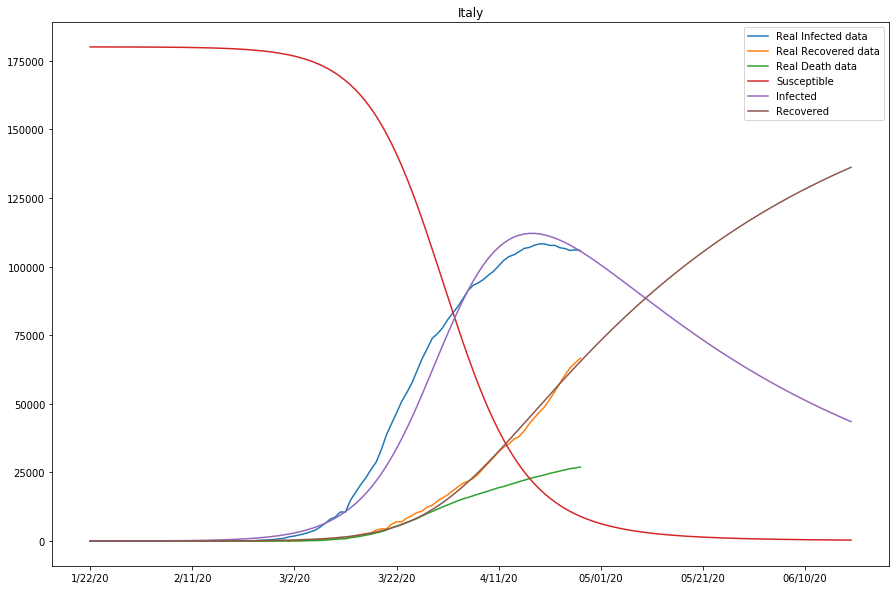

In [8]:
#Creo un nuovo dataframe completo
df = pd.DataFrame({'Real Infected data': extended_actual, 'Real Recovered data': extended_recovered, 'Real Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title(country)
df.plot(ax=ax)
print(f"country={country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
plt.show()

### Predizione valori passando una data

In [9]:
pred_date = "05/03/20"
next_date = list(new_index).index(pred_date)

print("The number of individuals Susceptible on {} are {}:".format(pred_date,prediction.y[0][next_date]))
print("The number of individuals Infected on {} are {}:".format(pred_date,prediction.y[1][next_date]))
print("The number of individuals Recovered on {} are {}:".format(pred_date,prediction.y[2][next_date]))

The number of individuals Susceptible on 05/03/20 are 5352.3945183464275:
The number of individuals Infected on 05/03/20 are 97902.97244853972:
The number of individuals Recovered on 05/03/20 are 76759.63303311385:


# #MODELLO SEIR (CINA & GIAPPONE)
# NOTA BENE: Per una descrizione dettagliata del paper utilizzato, relativi parametri e bibliografia guardare in Appendice

### Premessa
La struttura del modello di base si ispira a numerosi studi sulla progressione clinica naturale dell'infezione da COVID-19. Per un bel riassunto, vedi (Z. Wu e McGoogan 2020). Gli individui infetti non sviluppano immediatamente sintomi gravi, ma passano prima attraverso fasi più lievi dell'infezione. In alcuni studi, quelle che chiamiamo infezioni lievi sono raggruppate in due diverse categorie, lievi e moderate, in cui gli individui con infezione moderata mostrano segni radiografici di lieve polmonite. Questi casi lievi e moderati si verificano in proporzioni approssimativamente uguali (per esempio vedi P. Yang et al. (2020)). C'è qualche dibattito sul ruolo della trasmissione pre-sintomatica (che si verifica dallo stadio esposto) e dell'infezione e della trasmissione asintomatica per COVID-19. La versione del modello corrente non include questi effetti.

## Modello

<div style="text-align: center"><img src="../data/SEIRChinese-Model.png" alt="Drawing" style="width: 600px;"/></div>

### Equazioni

\begin{equation}
\begin{split}
\dot{S} &= -\beta_1 I_1 S -\beta_2 I_2 S - \beta_3 I_3 S\\
\dot{E} &=\beta_1 I_1 S +\beta_2 I_2 S + \beta_3 I_3 S - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

### Variabili
* $S$: Gli individui sensibili sono quelli che non sono mai stati infettati e quindi non hanno immunità contro COVID-19. Le persone sensibili sono esposte dopo essere state infettate dalla malattia.
* $E$: Gli individui esposti sono quelli che sono stati infettati da COVID-19 ma non sono ancora infettivi per gli altri. Un individuo rimane esposto per la durata del periodo di incubazione, dopo di che diventa infettivo e presenta lievi sintomi clinici (I1).
* $I_i$: Individui infetti in classe di gravità $i$. La gravità aumenta con $i$ e supponiamo che gli individui debbano passare attraverso tutte le classi precedenti
  * $I_1$: Gli individui con un'infezione lieve presentano sintomi come febbre e tosse e possono persino presentare una polmonite lieve ma non richiedono il ricovero in ospedale. Questi individui possono riprendersi o progredire fino allo stadio grave della malattia.
  * $I_2$: Gli individui con un'infezione grave hanno una polmonite grave e richiedono il ricovero in ospedale. Questi individui possono riprendersi o progredire fino allo stadio critico della malattia.
  * $I_3$: Gli individui con un'infezione critica sperimentano insufficienza respiratoria, shock settico e / o disfunzione o insufficienza multipla di organi e richiedono un trattamento in terapia intensiva. Questi individui possono guarire o morire a causa della malattia.
* $R$: Gli individui recuperati sono quelli che si sono ripresi e si presume siano immuni da future infezioni da COVID-19.
* $D$: Individui morti.
* $N=S+E+I_1+I_2+I_3+R+D$ Dimensione totale della popolazione (costante)

### Parametri
* $\beta_i$ tasso con cui le persone infette della classe $I_i$ contagiano i soggetti sensibili e li infettano
* $a$ tasso di progressione dalla classe esposta a quella infetta
* $\gamma_i$ tasso con cui le persone infette nella classe $I_i$ guariscono dalle malattie e diventano immuni
* $p_i$ tasso con cui le persone infette nella classe $I_i$ passano alla classe $I_{i + 1}$
* $\mu$ tasso di mortalità per gli individui nella fase più grave della malattia

### Rapporto riproduttivo di base

Idea: $R_0$ è la somma di
1. il numero medio di infezioni secondarie generate da un individuo nella fase $I_1$
2. la probabilità che un individuo infetto passi a $I_2$ moltiplicato per il numero medio di infezioni secondarie generate da un individuo nello stadio $I_2$
3. la probabilità che un individuo infetto passi a $ I_3 $ moltiplicato per il numero medio di infezioni secondarie generate da un individuo nello stadio $ I_3 $

\begin{equation}
\begin{split}
R_0 & = N\frac{\beta_1}{p_1+\gamma_1} + \frac{p_1}{p_1 + \gamma_1} \left( \frac{N \beta_2}{p_2+\gamma_2} + \frac{p_2}{p_2 + \gamma_2} \frac{N \beta_3}{\mu+\gamma_3}\right)\\
&= N\frac{\beta_1}{p_1+\gamma_1} \left(1 + \frac{p_1}{p_2 + \gamma_2}\frac{\beta_2}{\beta_1} \left( 1 + \frac{p_2}{\mu + \gamma_3} \frac{\beta_3}{\beta_2} \right) \right)
\end{split}
\end{equation}

### Ipotesi
1)Questo modello è formulato come un sistema di equazioni differenziali e l'output rappresenta quindi i valori attesi di ciascuna quantità. Non tiene conto degli eventi stocastici e quindi l'epidemia non può estinguersi anche quando raggiunge valori molto bassi (tranne quando un intervento viene interrotto, in quel caso il numero di individui in ogni stato viene arrotondato all'intero più vicino). Il modello non riporta la varianza prevista nelle variabili, che a volte può essere grande.<br>
2)Gli individui devono attraversare uno stadio lieve prima di raggiungere uno stadio grave o critico<br>
3)Gli individui devono attraversare una fase grave prima di raggiungere una fase critica<br>
4)Solo gli individui in una fase critica muoiono<br>
5)Tutti gli individui hanno uguali velocità di trasmissione e uguale suscettibilità alle infezioni<br>

### Definizione del modello SEIR

In [10]:
#Definizione delle equazioni differenziali

# Non tenere traccia di S perché tutte le variabili devono ammontare a 1
#include la prima voce vuota nel vettore per beta, gamma, p in modo che gli indici si allineino in equazioni e codice.
#In futuro potrebbe includere il recupero o l'infezione dalla classe esposta (asintomatici)

def seir(y,t,b,a,g,p,u,N): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy

### Definiamo i parametri in base alle osservazioni cliniche reperibili da https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus
Tali valori sono stati arrotondati e scelti tra l'intervallo di min e max dei valori disponibili nel repository, in maniera approssimativa sulle diverse regioni, per avere un valore che potesse esprimere l'andamento nazionale.

### Correlazione delle osservazioni cliniche ai parametri del modello
Per determinare i parametri del modello coerenti con i dati clinici attuali, raccogliamo i seguenti valori dai valori dal paper, quindi utilizziamo le formule seguenti per metterli in relazione con il tasso dei parametri nel modello. Si noti che i valori del paper sono durate medie.

IncubPeriod: periodo medio di incubazione, giorni
<br>DurMildInf: durata media delle infezioni lievi, giorni
<br>FracMild: frazione media di infezioni (sintomatiche) lievi
<br>FracSevere: frazione media di infezioni (sintomatiche) gravi
<br>FracCritical: frazione media di infezioni (sintomatiche) critiche
<br>CFR: tasso di mortalità per caso (frazione di infezioni che alla fine portano alla morte)
<br>DurHosp: durata media del ricovero (tempo al recupero) per soggetti con infezione grave, giorni
<br>TimeICUDeath: durata media dell'ammissione in terapia intensiva (fino alla morte o al recupero), giorni

In [11]:
# Definire i parametri in base alle osservazioni cliniche
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

IncubPeriod=5  #Periodo di incubazione, giorni
DurMildInf=10 #Durata delle infezioni lievi, giorni
FracMild=0.8  #Tasso delle infezioni lievi
FracSevere=0.15 #Tasso delle infezioni gravi
FracCritical=0.05 #Tasso delle infezioni critiche
CFR=0.02 #Tasso di mortalità dei casi (tasso di infezione che causa la morte)
TimeICUDeath=7 #Tempo dall'ammissione dalla terapia intensiva alla morte, giorni
DurHosp=11 #Durata del ricovero, giorni


Dai precedenti valori adesso tiriamo fuori i parametri per addestrare il modello.

In [12]:
# Definire i parametri iniziali ed eseguire ODE (Equazione Differenziale Ordinaria)

N=1000 #Popolazione chiusa
#Li definiamo array poichè abbiamo 3 compartimenti I
b=np.zeros(4) #definisco l'array beta vuoto
g=np.zeros(4) #definisco l'array gamma vuoto
p=np.zeros(3) #definisco l'array p vuoto

a=1/IncubPeriod #alfa tasso di progressione dalla classe esposta a quella infetta

u=(1/TimeICUDeath)*(CFR/FracCritical) #tasso di mortalità per gli individui nella fase più grave della malattia

g[3]=(1/TimeICUDeath)-u #tasso con cui le persone infette nella classe $I_i$ guariscono dalle malattie e diventano immuni

#tasso critico p
p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)) #tasso con cui le persone infette nella classe $I_i$ passano alla classe $I_{i + 1}$
#tasso critico
g[2]=(1/DurHosp)-p[2]

# tassp lieve
g[1]=(1/DurMildInf)*FracMild
#tasso lieve p
p[1]=(1/DurMildInf)-g[1]

#b=2e-4*np.ones(4) # tutte le fasi trasmettono allo stesso modo
b=2.5e-4*np.array([0,1,0,0]) # Casi ospedalizzati non trasmessi

#Calcolo del basic reproductive ratio
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
print("R0 = {0:4.1f}".format(R0))

R0 =  2.5


In [13]:
print(b)
print(a)
print(g)
print(p)
print(u)

[0.      0.00025 0.      0.     ]
0.2
[0.         0.08       0.06818182 0.08571429]
[0.         0.02       0.02272727]
0.057142857142857134


(1, 1000)

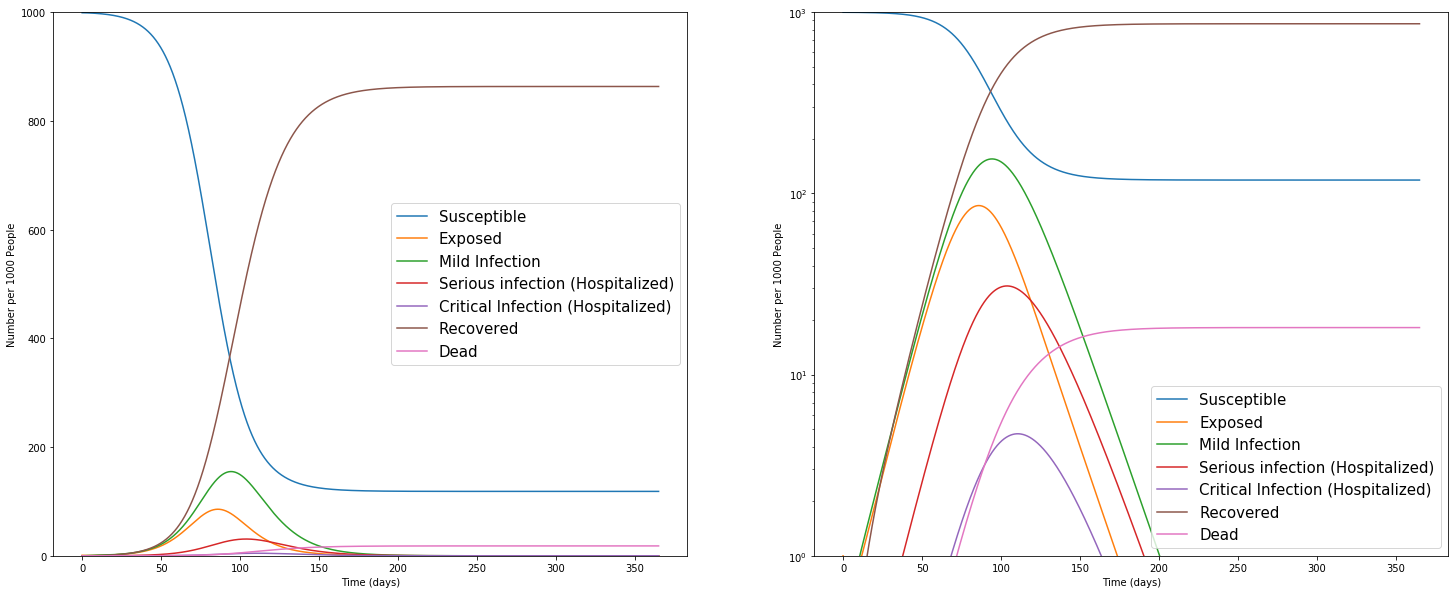

In [14]:
tmax=365
tvec=np.arange(0,tmax,0.1)
ic=np.zeros(6)
ic[0]=1

soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N))
soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(tvec,soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("Susceptible","Exposed","Mild Infection","Serious infection (Hospitalized)","Critical Infection (Hospitalized)","Recovered","Dead"))
plt.ylim([0,1000])

#Stessa plot ma su scala logaritmica
plt.subplot(1,2,2)
plt.plot(tvec,soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("Susceptible","Exposed","Mild Infection","Serious infection (Hospitalized)","Critical Infection (Hospitalized)","Recovered","Dead"))
plt.ylim([1,1000])
#plt.tight_layout()

- All'inizio della simulazione, tutti gli individui sono liberi da malattia e sensibili (S) all'infezione da COVID-19.
- Dopo che COVID-19 è stato introdotto nella popolazione, gli individui sensibili si ammalano di malattia e il numero di individui infetti (I1, I2 e I3) aumenta, portando ad un aumento del numero di soggetti che guariscono (R) o muoiono (D).
- Alla fine, mentre la malattia si fa strada attraverso la popolazione, il numero di individui che si riprendono (R) dalla malattia supererà quelli che non hanno ancora avuto la malattia (S).
- L'epidemia termina quando non ci sono abbastanza soggetti sensibili per sostenere un'ulteriore diffusione della malattia.

### Tasso di crescita epidemica precoce
All'inizio dell'epidemia, prima che i suscettibili tocchino lo zero, l'epidemia cresce a una velocità esponenziale r, che può anche essere descritta con un tempo di raddoppio T2 = ln (2) / r. Durante questa fase tutte le classi infette crescono alla stessa velocità delle altre e delle persone decedute e guarite. Anche il numero cumulativo di infezioni che si sono verificate dall'inizio dell'epidemia cresce allo stesso ritmo. Questa velocità può essere calcolata dall'autovalore dominante del sistema di equazioni linearizzato nel limite per S = N. 

Durante questa fase iniziale di crescita esponenziale, ci sarà un rapporto fisso di individui tra qualsiasi coppia di compartimenti. Questo rapporto atteso potrebbe essere utilizzato per stimare la quantità di sottostima nei dati. Ad esempio, potremmo pensare che tutti i decessi siano stati segnalati, ma che alcune infezioni lievi potrebbero non essere segnalate, poiché questi pazienti potrebbero non cercare assistenza sanitaria o potrebbero non avere la priorità per i test. Questi rapporti hanno valori previsti nel modello per un set fisso di parametri. Possono essere calcolati trovando l'autovettore corrispondente all'autovalore dominante (r) per il sistema linearizzato sopra descritto. I rapporti che si discostano da questi valori suggeriscono o a) una sottostima di casi relativi a decessi, oppure b) differenze locali nei parametri clinici della progressione della malattia. I rapporti previsti sono:
<div style="text-align: center"><img src="../data/growth-rate.png" alt="Drawing" style="width: 600px;"/></div>

In [15]:
# Ottiene il tasso di crescita osservato r (e il tempo di raddoppio) per una particolare variabile tra i punti temporali selezionati
# (tutte le classi infette alla fine crescono allo stesso ritmo durante l'infezione precoce)
# Non abbiamo una semplice formula analitica per r per questo modello a causa della complessità degli stadi

def growth_rate(tvec,soln,t1,t2,i):
    i1=np.where(tvec==t1)[0][0]
    i2=np.where(tvec==t2)[0][0]
    r=(np.log(soln[i2][1])-np.log(soln[i1][1]))/(t2-t1) #cerco sugli infetti
    DoublingTime=np.log(2)/r

    return r, DoublingTime #rate e tempo espresso in giorni

In [16]:
(r,DoublingTime)=growth_rate(tvec,soln,10,20,1) #10 corrisponde a 100 e 20 a 200 poichè l'intervallo di integazione è 0.1
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r,DoublingTime))

The epidemic growth rate is = 0.08 per day and the doubling time  9.0 days 


### Introduzione di una misura di distanza sociale che riduce la velocità di trasmissione del contagio

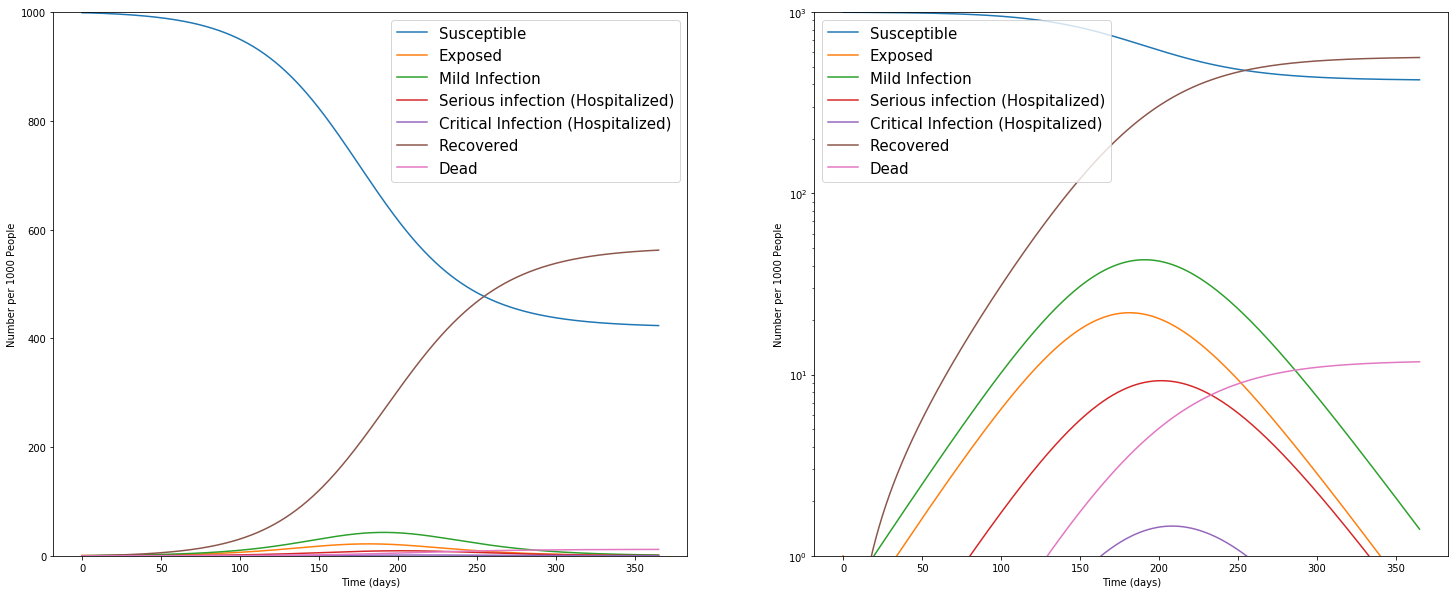

R0 under intervention =  1.5
The epidemic growth rate is = 0.03 per day and the doubling time 23.3 days 


In [17]:
bSlow=0.6*b #rate di contanimento pari a 0.5
R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))

solnSlow=odeint(seir,ic,tvec,args=(bSlow,a,g,p,u,N))
solnSlow=np.hstack((N-np.sum(solnSlow,axis=1,keepdims=True),solnSlow))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(tvec,solnSlow)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("Susceptible","Exposed","Mild Infection","Serious infection (Hospitalized)","Critical Infection (Hospitalized)","Recovered","Dead"))
plt.ylim([0,1000])

#Stesso plot ma su scala logaritmica
plt.subplot(1,2,2)
plt.plot(tvec,solnSlow)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("Susceptible","Exposed","Mild Infection","Serious infection (Hospitalized)","Critical Infection (Hospitalized)","Recovered","Dead"))
plt.ylim([1,1000])

(rSlow,DoublingTimeSlow)=growth_rate(tvec,solnSlow,30,40,1)

plt.show()
print("R0 under intervention = {0:4.1f}".format(R0Slow))
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(rSlow,DoublingTimeSlow))

### OSSERVAZIONE: Possiamo notare come, adottando misure di contenimento, la risoluzione dell'epidemia assuma tempi più lunghi rispetto al caso senza misure.

### Confrontiamo la crescita epidemica con e senza intervento

Text(0.5, 1.0, 'All infectious cases')

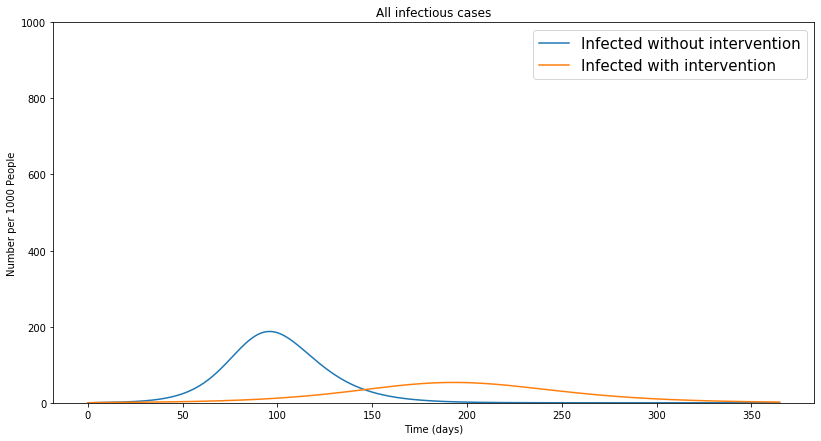

In [18]:
### Tutti i casi infettivi (non esposti)

plt.figure(figsize=(30,7))
plt.subplot(1,2,1)
plt.plot(tvec,np.sum(soln[:,2:5],axis=1,keepdims=True))
plt.plot(tvec,np.sum(solnSlow[:,2:5],axis=1,keepdims=True))
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("Infected without intervention","Infected with intervention"))
plt.ylim([0,1000])
plt.title('All infectious cases')

## COVID19 Casi vs Capacità Ospedaliera
I valori sono stati reperiti dal seguente link https://docs.google.com/spreadsheets/d/1zZKKnZ47lqfmUGYDQuWNnzKnh-IDMy15LBaRmrBcjqE

A seconda dello stadio di gravità ($ I_i $) dell'infezione COVID-19, i pazienti necessitano di diversi livelli di assistenza medica.

Le persone in $ I_1 $ hanno un'infezione "lieve", nel senso che hanno tosse / febbre / altri sintomi simil-influenzali e possono anche avere una polmonite lieve. La polmonite lieve non richiede ricovero in ospedale, sebbene in molte località di epidemia come la Cina e la Corea del Sud tutti i pazienti sintomatici vengano ricoverati in ospedale. Ciò probabilmente ridurrà la diffusione e monitorerà questi pazienti nel caso in cui progrediscano rapidamente verso risultati peggiori. Tuttavia, è un onere enorme per il sistema sanitario.

Gli individui in $ I_2 $ hanno un'infezione "grave", che è classificata dal punto di vista medico come una delle seguenti: "dispnea, frequenza respiratoria 30 / min, saturazione di ossigeno nel sangue 93%, pressione parziale dell'ossigeno arterioso alla frazione del rapporto di ossigeno inspirato $ < $ 300, il polmone si infiltra in $> $ 50% entro 24 a 48 ore ". Queste persone richiedono il ricovero in ospedale ma possono essere curate in reparti regolari. Possono richiedere ossigeno supplementare.

Gli individui in $ I_3 $ hanno un'infezione "critica", che è classificata come una delle seguenti: "insufficienza respiratoria, shock settico e / o disfunzione o insufficienza multipla di organi". Richiedono cure a livello di terapia intensiva, generalmente perché necessitano di ventilazione meccanica.

Consideriamo diversi scenari per i requisiti di cura. Una variazione tra gli scenari è se includiamo il ricovero in ospedale per tutti gli individui o solo quelli con infezione grave o critica. Un altro è la cura dei pazienti critici. Se le ICU sono piene, gli ospedali hanno sviluppato protocolli per l'influenza pandemica per fornire ventilazione meccanica al di fuori delle normali strutture di terapia intensiva e requisiti di personale. Rispetto ai protocolli di ventilazione "convenzionali", esistono protocolli di "emergenza" e "crisi" che possono essere adottati per aumentare i carichi dei pazienti. Questi protocolli implicano un aumento dei pazienti: tasso del personale, utilizzo di letti non in terapia intensiva e coinvolgimento di specialisti di terapia non critica nella cura dei pazienti.

In [19]:
#Sorgente: https://docs.google.com/spreadsheets/d/1zZKKnZ47lqfmUGYDQuWNnzKnh-IDMy15LBaRmrBcjqE

# Tutti i valori sono regolati per una maggiore occupazione a causa della stagione influenzale

AvailHospBeds=2.6*(1-0.66*1.1) #Letti ospedalieri disponibili per 1000 persone in base al numero totale di letti e occupazione
AvailICUBeds=0.26*(1-0.68*1.07) #Letti ICU disponibili per 1000 posti letto, in base al numero totale di letti e occupazione. Conta solo letti adulti non neonatali / pediatrici
ConvVentCap=0.062 #Numero di eccessi stimato di pazienti che potrebbero essere ventilati (per 1000 persone) utilizzando protocolli convenzionali
ContVentCap=0.15 #Numero stimato in eccesso di pazienti che potrebbero essere ventilati (per 1000 persone) utilizzando protocolli di emergenza
CrisisVentCap=0.42 #Numero stimato in eccesso di pazienti che potrebbero essere ventilati (per 1000 persone) utilizzando i protocolli di crisi


### Presupposto 1
* Solo i casi gravi o critici vanno in ospedale
* Tutti i casi critici richiedono cure ICU e ventilazione meccanica

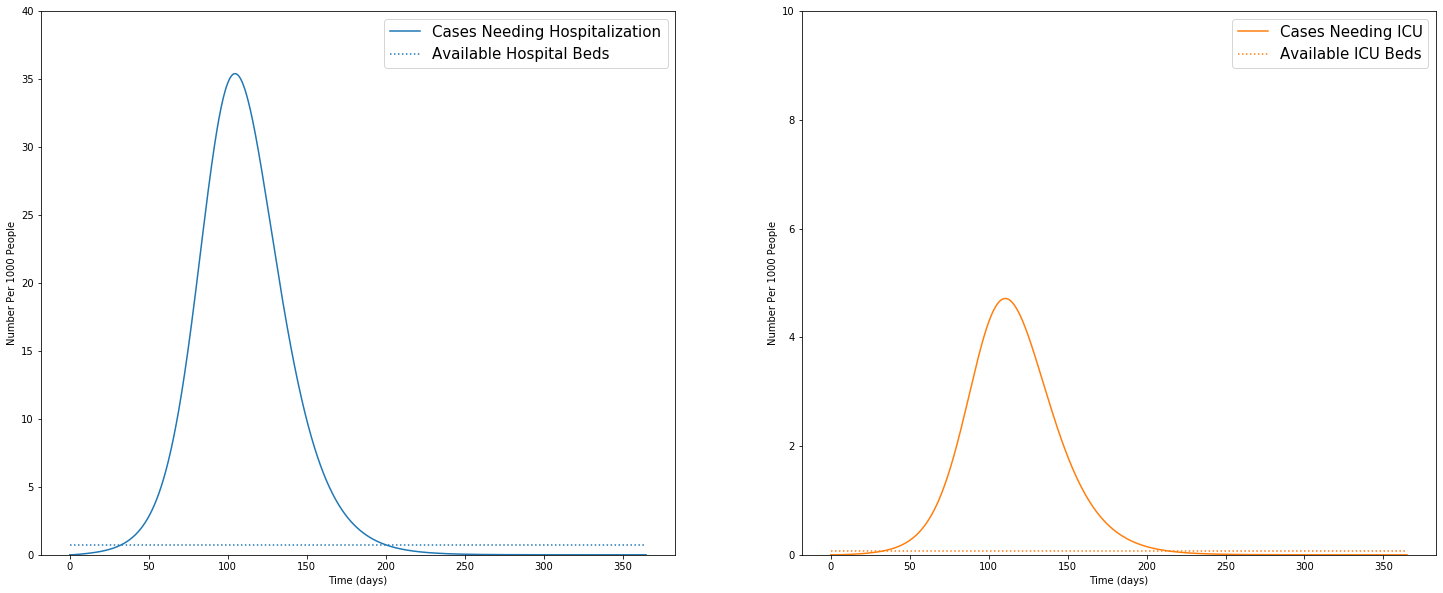

Hospital and ICU beds are filled by COVID19 patients after 32.2 and 33.2 days


In [20]:
NumHosp=soln[:,3]+soln[:,4] #Infezioni gravi (ospedalizzati) e critiche (ICU) = ospedalizzati totali
NumICU=soln[:,4] #Infezione critiche (ICU) = ICU

# Plot per gli ospedalizzati
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(tvec,NumHosp) #Curva ospedalizzati
plt.plot(np.array((0, tmax)),AvailHospBeds*np.ones(2),color='C0',linestyle=":") #Limite letti disponibili
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Hospitalization","Available Hospital Beds"))
ipeakHosp=np.argmax(NumHosp) #troviamo indice picco
peakHosp=10*np.ceil(NumHosp[ipeakHosp]/10)#troviamo il picco
plt.ylim([0,peakHosp])

#Ripeto la procedura per le ICU
plt.subplot(1,2,2)
plt.plot(tvec,NumICU,color='C1')
plt.plot(np.array((0, tmax)),AvailICUBeds*np.ones(2),color='C1',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing ICU","Available ICU Beds"))
ipeakICU=np.argmax(NumICU) #troviamo indice picco
peakICU=10*np.ceil(NumICU[ipeakICU]/10)#Troviamo il picco (giorni)
plt.ylim([0,peakICU])
plt.ylim([0,10])

#Trovo il momento in cui i casi ospedalizzati = capacità
icross=np.argmin(np.abs(NumHosp[0:ipeakHosp]-AvailHospBeds)) #Trovo l'intersezione prima del picco
TimeFillBeds=tvec[icross]

#Trovo il momento in cui i casi di ICU = capacità
icross=np.argmin(np.abs(NumICU[0:ipeakICU]-AvailICUBeds)) #Trovo l'intersezione prima del picco
TimeFillICU=tvec[icross]

plt.show()
print("Hospital and ICU beds are filled by COVID19 patients after {0:4.1f} and {1:4.1f} days".format(TimeFillBeds,TimeFillICU))


Si noti che non abbiamo preso in considerazione la capacità limitata nel modello stesso. Se gli ospedali sono pieni, il tasso di mortalità aumenterà, poiché le persone con infezioni gravi spesso muoiono senza cure mediche. Probabilmente anche la velocità di trasmissione aumenterà, poiché qualsiasi assistenza domiciliare informale per questi pazienti probabilmente non includerà il livello di isolamento / precauzioni utilizzato in un ospedale.

#### Consentire la ventilazione meccanica al di fuori delle ICU utilizzando la capacità di emergenza o di crisi

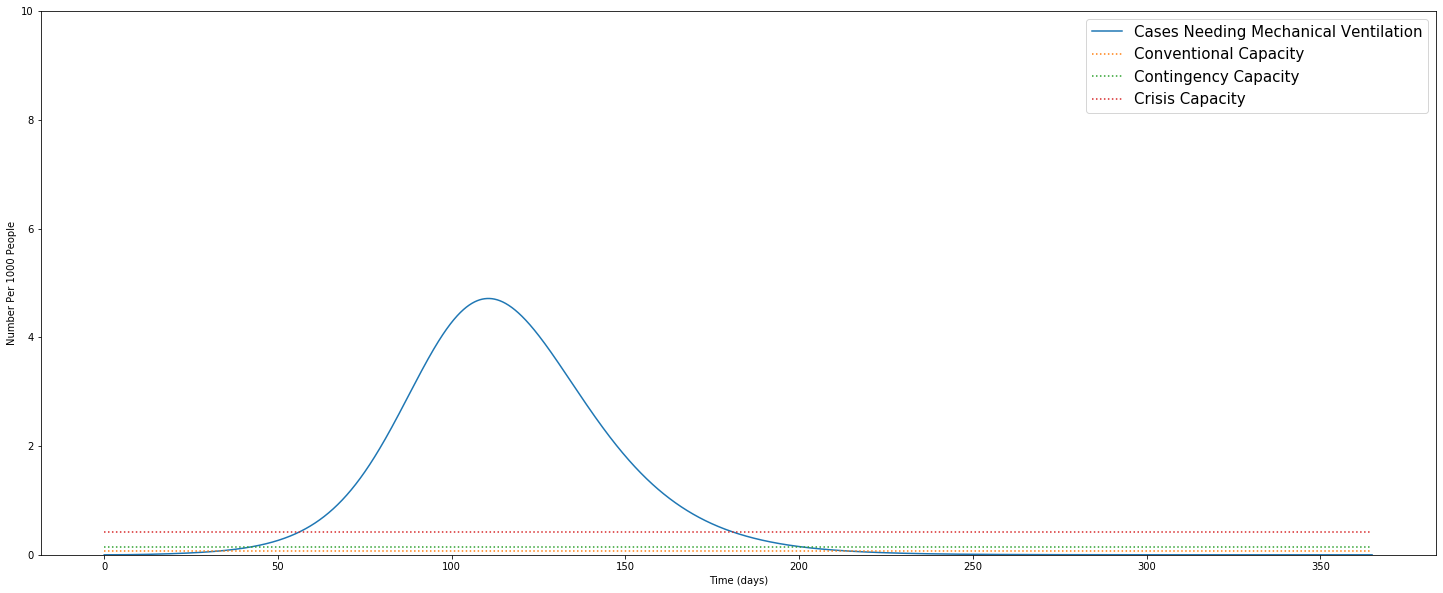

Capacity for mechanical ventilation is filled by COVID19 patients after 31.6 (conventional), 42.7 (contingency) and 56.2 (crisis) days


In [21]:
plt.figure(figsize=(25,10))
plt.plot(tvec,NumICU)
plt.plot(np.array((0, tmax)),ConvVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),ContVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),CrisisVentCap*np.ones(2),linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Mechanical Ventilation","Conventional Capacity","Contingency Capacity","Crisis Capacity"))
plt.ylim([0,peakICU])
plt.ylim([0,10])

#Trova l'istante in cui i casi di terapia intensiva = capacità convenzionale
icrossConv=np.argmin(np.abs(NumICU[0:ipeakICU]-ConvVentCap)) # trova intersezione prima del picco
TimeConvCap=tvec[icrossConv]
icrossCont=np.argmin(np.abs(NumICU[0:ipeakICU]-ContVentCap)) # trova intersezione prima del picco
TimeContCap=tvec[icrossCont]
icrossCrisis=np.argmin(np.abs(NumICU[0:ipeakICU]-CrisisVentCap)) # trova intersezione prima del picco
TimeCrisisCap=tvec[icrossCrisis]

plt.show()
print("Capacity for mechanical ventilation is filled by COVID19 patients after {0:4.1f} (conventional), {1:4.1f} (contingency) and {2:4.1f} (crisis) days".format(TimeConvCap,TimeContCap,TimeCrisisCap))

Paragone al caso con intervento

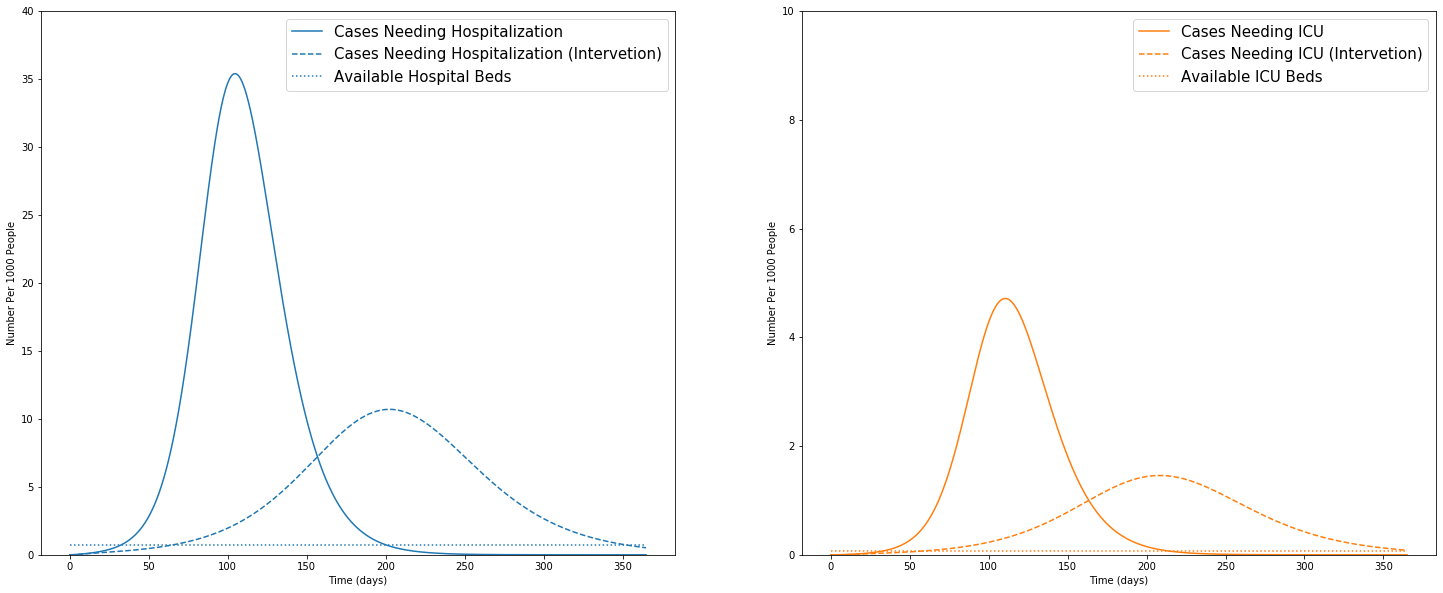

With intervention, hospital and ICU beds are filled by COVID19 patients after 64.4 and 59.2 days


In [22]:
NumHospSlow=solnSlow[:,3]+solnSlow[:,4]
NumICUSlow=solnSlow[:,4]

plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(tvec,NumHosp)
plt.plot(tvec,NumHospSlow,color='C0',linestyle="--")
plt.plot(np.array((0, tmax)),AvailHospBeds*np.ones(2),color='C0',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Hospitalization","Cases Needing Hospitalization (Intervetion)","Available Hospital Beds"))
plt.ylim([0,peakHosp])

plt.subplot(1,2,2)
plt.plot(tvec,NumICU,color='C1')
plt.plot(tvec,NumICUSlow,color='C1',linestyle="--")
plt.plot(np.array((0, tmax)),AvailICUBeds*np.ones(2),color='C1',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing ICU","Cases Needing ICU (Intervetion)","Available ICU Beds"))
plt.ylim([0,peakICU])

#Trova l'istante in cui i casi ricoverati in ospedale = capacità
ipeakHospSlow=np.argmax(NumHospSlow) #find peak
icross=np.argmin(np.abs(NumHospSlow[0:ipeakHospSlow]-AvailHospBeds)) # trova intersezione prima del picco
TimeFillBedsSlow=tvec[icross]

#Trovo l'istante in cui i casi ICU = capacità
ipeakICUSlow=np.argmax(NumICUSlow) # trova il picco
icross=np.argmin(np.abs(NumICUSlow[0:ipeakICU]-AvailICUBeds)) # trova intersezione prima del picco
TimeFillICUSlow=tvec[icross]

plt.show()
print("With intervention, hospital and ICU beds are filled by COVID19 patients after {0:4.1f} and {1:4.1f} days".format(TimeFillBedsSlow,TimeFillICUSlow))

E per una maggiore capacità di ventilazione meccanica:

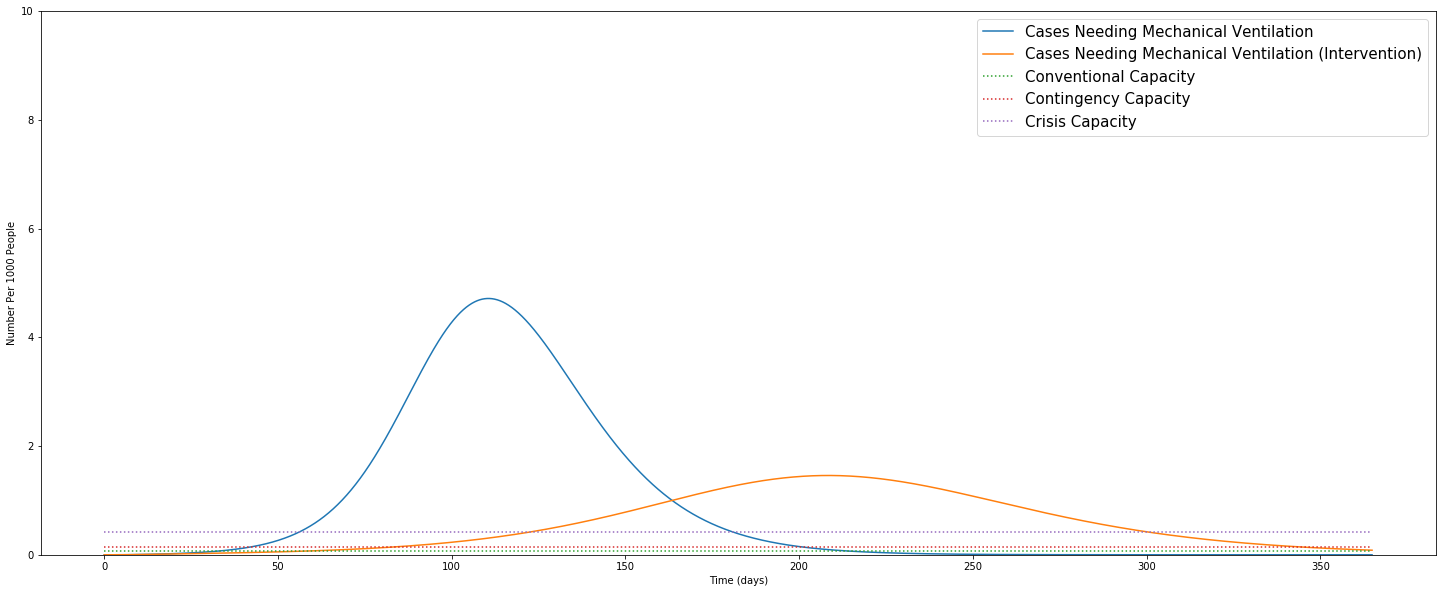

Capacity for mechanical ventilation is filled by COVID19 patients after 54.8 (conventional), 84.8 (contingency) and 122.6 (crisis) days


In [23]:
plt.figure(figsize=(25,10))
plt.plot(tvec,NumICU)
plt.plot(tvec,NumICUSlow)
plt.plot(np.array((0, tmax)),ConvVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),ContVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),CrisisVentCap*np.ones(2),linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Mechanical Ventilation","Cases Needing Mechanical Ventilation (Intervention)","Conventional Capacity","Contingency Capacity","Crisis Capacity"))
plt.ylim([0,peakICU])

#Trovare l'istante in cui casi ICU = capacità convenzionale (con intervento)
icrossConvSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-ConvVentCap)) # trova intersezione prima del picco
TimeConvCapSlow=tvec[icrossConvSlow]
icrossContSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-ContVentCap)) # trova intersezione prima del picco
TimeContCapSlow=tvec[icrossContSlow]
icrossCrisisSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-CrisisVentCap)) # trova intersezione prima del picco
TimeCrisisCapSlow=tvec[icrossCrisisSlow]

plt.show()
print("Capacity for mechanical ventilation is filled by COVID19 patients after {0:4.1f} (conventional), {1:4.1f} (contingency) and {2:4.1f} (crisis) days".format(TimeConvCapSlow,TimeContCapSlow,TimeCrisisCapSlow))

Interpretazione: mentre gli interventi che riducono l'infettività "appiattiscono la curva", i casi continuano a MODIFICARE la capacità dell'ospedale. Non c'è modo di avvicinarsi in alcun modo a rimanere sotto la capacità dei letti ospedalieri o della capacità di ventilazione meccanica senza ridurre $ R_0 <1 $.

### Presupposto 2
* Tutti i casi vanno in ospedale
* Tutti i casi critici richiedono cure ICU e ventilazione meccanica

Nota: non ha senso eseguire questo scenario perché sarebbe ancora più estremo dell'Assunzione 1 (i casi lievi sono rimasti a casa) e l'Assunzione 1 già porta a un rapido afflusso di risorse ospedaliere


### Presupposto 3
* Solo i casi gravi o critici vanno in ospedale
* Tutti i casi critici richiedono cure ICU e ventilazione meccanica
* Quando viene superata la capacità dell'ospedale, l'individuo muore

Nota: potrebbe essere usato per simulare gli aumenti attesi nella morte se la capacità fosse superata

## Modelli Alternativi

Per continuare:
* Supponiamo che ~ il 30% dei casi sia asintomatico (Ciò porterebbe a una reinterpretazione dei tassi riportati di infezione grave e critica, quindi la prevalenza di queste fasi diminuirà)
* Un modello parallelo invece della serie, del decorso della malattia (perché non è chiaro se è realistico che gli individui che passano attraverso dallo stadio lieve allo stato grave trascorrano tanto tempo nello stadio lieve, come anche gli individui che non progrediscono mai)
* Includiamo la trasmissione pre-sintomatica (per circa gli ultimi ~ 2 giorni del periodo esposto, come stimato in alcuni studi)

# #MODELLO SEIR CINESE AGGIORNATO

1) Il modello ora include la possibilità di infezione asintomatica. Dopo aver lasciato il compartimento E, una parte f di individui sviluppa infezione asintomatica (entra nella classe I0), mentre la parte rimanente 1 − f sviluppa un'infezione sintomatica (entra nella classe I1). L'infezione asintomatica non passa mai a stadi più gravi. Il tasso di recupero dall'infezione asintomatica è γ0. Gli individui con infezione asintomatica possono trasmettere ad altri al tasso β0.

2) Il modello ora include anche la possibilità che individui esposti che non hanno ancora sviluppato sintomi possano essere ancora in grado di trasmettere il virus ("trasmissione presintomatica"). Per modellare questo, dividiamo la classe E in due classi separate, E0 (nessun sintomo o trasmissione) ed E1 (nessun sintomo ma può trasmettere). Il tasso di transizione da E0 è a0 e da E1 è a1.

3) Ora includiamo l'opzione per la stagionalità nel tasso di trasmissione. Tutti i tassi di trasmissione sono modificati da un fattore σ (t) = 1 + ϵcos (2π (t − ϕ)) dove ϵ∈ [0,1] è l'ampiezza relativa delle oscillazioni stagionali e ϕ∈ [−∞, ∞] è la fase che determina il tempo (in anni) del picco nella trasmissione rispetto al momento in cui inizia la simulazione. I valori immessi dall'utente per i tassi di trasmissione sono interpretati come i tassi al tempo zero della simulazione. Questo input sarà uguale al picco di trasmissione se ϕ = 0, come trasmissione minima di ϕ = 365 / 4∼90, e come trasmissione media nel tempo se ϕ = 365 / 2∼180, ad esempio.

Le equazioni del modello aggiornato sono:
![title](../data/SEIRChinese-Model-Updated.png)

Gli parametri extra sono:
- FracAsym: frazione di tutte le infezioni asintomatiche
- PresymPeriod: durata della fase infettiva del periodo di incubazione
- DurAsym: durata dell'infezione asintomatica

E le formule (per i tassi costanti) ottenute da questi input sono:
- a1=1/PresymPeriod
- a0=(IncubPeriod-PresymPeriod)^(-1)
- f=FracAsym
- g0=1/DurAsym

Il rapporto riproduttivo di base diventa:
![title](../data/R0-updated.png)

### Output
#### Parametri di valutazione del modello dinamico
I valori scelti sono quelli portati nella seguente tabella. Si noti che le velocità di trasmissione scelte sono sempre ridimensionate di N, in modo che β ∗ N sia costante quando N cambia.

![title](../data/tabella1-updated.png)

#### Rapporti dei casi durante la fase iniziale di crescita
Questi valori vengono calcolati in base ai parametri del modello corrente.

![title](../data/tabella2-updated.png)

# #MODELLO SEIR (Italia - Lombardia & Emilia Romagna)

Abbiamo usato un modello SEIR (suscettibili-esposti-infetti-recuperati) epidemiologico deterministico, che comprende scomparti rilevanti per interventi di sanità pubblica come la quarantena e isolamento. Come mostrato nella Figura, è stato usato il modello SEIR stimato sui dati cinesi inserendo un nuovo compartimento 𝐿 per la popolazione infetta isolata, vale a dire gli individui testati positivi che non hanno bisogno di cure ospedaliere.

![title](../data/SEIR.png)

<div style="text-align: center"><img src="../data/SEIR-Equations.png" alt="Drawing" style="width: 400px;"/></div>

Il modello è descritto da un sistema accoppiato di equazioni differenziali ordinarie non lineari che descrivono l'evoluzione dei compartimenti nel tempo. Il modello è stato inizializzato con i dati regionali stimati dalla Protezione Civile per la Lombardia
e l'Emilia-Romagna il 9 marzo (il primo giorno della quarantena nazionale). Altri parametri immessi, ad esempio le dimensioni della popolazione il giorno 0 (9 marzo) sono stati ottenuti raccogliendo informazioni dalle statistiche ufficiali e fatte alcune ipotesi per l'inserimento di dati mancanti.

* S = Suscettibili
* E = Esposti
* A = Infetti ma non sintomatici
* I = Infetti con sintomi
* H = Ospedalizzati
* R = Guariti
* Sq = Suscettibili in quarantena
* Eq = Esposti in quarantena
* I casi registrati possono finire in ospedale (H) oppure rimanere a casa con sintomi lievi (L).

![title](../data/Table1.png)

![title](../data/Table2.png)

Le misure di contenimento sono state parametrizzate tramite la funzione "Contatti" c(t). Hanno ipotizzato che l'attuazione delle misure di contenimento abbia ridotto i contatti medi rapidamente a un valore molto basso. Questo valore è stato mantenuto fino alle ipotesi di revoca del contenimento e quindi è stata eseguita un'analisi di sensibilità per indicare l'intervallo dei risultati corrispondenti a diverse opzioni e livelli di sollevamento del contenimento. Pertanto, il contatto rate c(t) è una funzione decrescente rispetto al tempo t, che è data da:

<div style="text-align: center"><img src="../data/c1.png" alt="Drawing" style="width: 200px;"/></div>

dove c0 è la velocità di contatto al momento iniziale (= 14.781), cb è il tasso di contatto minimo secondo le attuali strategie di controllo in Italia, e r1 è il tasso di contatto esponenziale decrescente. Quindi viene definita anche una funzione di rilascio dei contatti in termini di tempo di rilascio Tc, vale a dire il tempo in cui inizia il sollevamento del contenimento (dopo 60, 90 e 120 giorni nella nostra analisi di sensibilità). Le scale temporali esponenziali sono date dalle costanti r1 e r11 impostate a 1,3 e 0,5 days − 1, rispettivamente.

<div style="text-align: center"><img src="../data/c2.png" alt="Drawing" style="width: 230px;"/></div>

In modo che la funzione di contatto totale sia:

<div style="text-align: center"><img src="../data/c.png" alt="Drawing" style="width: 230px;"/></div>

dove 𝜃(𝑡) è una step function tale che è 1 per 𝑡 <0 e 0 altrimenti. Allo stesso modo, impostiamo il tasso di diagnosi 𝛿𝐼(𝑡) per gli individui infetti sintomatici (funzione crescente rispetto al tempo t):

<div style="text-align: center"><img src="../data/delta1.png" alt="Drawing" style="width: 210px;"/></div>

dove 𝛿𝐼0 = 𝛿𝐼(0) (𝛿𝐼0=0.13266 e r2=0.3283) è il valore iniziale del tasso di diagnosi e 𝛿𝐼𝑓 = lim 𝑡 → ∞ 𝛿𝐼 (𝑡) (1/𝛿𝐼𝑓=0.3654) è il tasso di diagnosi massimo (finale) con 𝛿𝐼0 <𝛿𝐼𝑓. Questo presupposto fornisce una misura delle risorse disponibili da affrontare la pandemia.

Inoltre, non appena i dati sono stati resi disponibili, è diventato evidente che i dati più affidabili erano il numero di ricoveri. È difficile nello sviluppo dell'emergenza ottenere dati affidabili circa gli infetti, sintomatici e anche il numero di deceduti; tali dati sono soggetti a modifica della classificazione o all'incapacità di classificarli. Pertanto, il modo migliore per vincolare il modello era fare affidamento sui numeri di ricovero inclusi nel compartimento H. E' stata usata una semplice tecnica di spinta per costringere il modello a riprodurre l'evoluzione dell'ospedalizzazione:

<div style="text-align: center"><img src="../data/tao-H.png" alt="Drawing" style="width: 150px;"/></div>

dove 𝜏 è il tempo di scostamento in giorni inverso, più breve è il tempo più forte è il vincolo. Gli esperimenti sono stati ottenuti variando il valore minimo dei contatti raggiunto dalle misure di contenimento, che è ovviamente difficile da misurare con certezza e quindi è un candidato adatto per la sensibilità. I valori di contatto sono variabili e variano da 3-4 contatti per confinamenti molto stretti a 15 contatti al giorno per situazioni di insediamenti densi.
Il modello sarà in grado di fornire informazioni sullo sviluppo dei casi d'infezione peggiori e migliori ed essere utilizzato per prevedere l'evoluzione della diffusione dell'infezione e dei ricoveri in diverse condizioni di allontanamento sociale.

### OSSERVAZIONE: 
Per semplicità di sviluppo nel trovare il c, abbiamo riportato quello già calcolato per la Lombardia e l'Emilia, ma comunque abbiamo implementato la funzione che genera una lista di c al variare di theta nel caso in cui si volessero testare nuovi scenari cambiando la funzione di contatto; mentre per delta_I siamo riusciti a replicare la funzione utilizzando i valori riportati in https://www.sciencedirect.com/science/article/pii/S246804272030004X, ma variando delta_IF, poichè riteniamo che le risorse disponibili siano inferiori rispetto a quelle Cinesi (soprattutto in un contesto ristretto di regione).

In [24]:
def c_compute(t,Tc,cb,cf,c0=14.781,r1=1.3,r11=0.5):
    c1=(c0-cb)*math.exp(-r1*t)+cb
    c2=(cf-cb)*(1-math.exp(-r11*(t-Tc)))+cb
    thetavec=np.arange(0,1,0.1)
    c_list = list()
    for theta_it in thetavec:
        c=theta_it*(t-Tc)*c1+theta_it*(Tc-t)*c2
        c_list.append(c)
    return c_list

#print(c_compute(120,60,3.2,3,14.781,1.3,0.5))

In [25]:
def delta_I(t,delta_I0=0.13266, r2=0.3283, delta_IF=(1/0.3654)):
    delta_t = (((delta_I0 - delta_IF)*math.exp(-r2*t))+delta_IF)
    return delta_t

In [26]:
pc_data = pd.read_csv('../data/COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv')

In [27]:
FMT = '%d-%m-%Y'
start_date = '09-03-2020'
tmax = 120
tvec=np.arange(0,tmax,0.0416)
date = list()
for i in range (0,tmax):
    date.append(datetime.strptime(start_date, FMT)+timedelta(days=i))

### Funzione per il calcolo dei morti

Poichè nel paper è stato tenuto conto della mortalità in maniera indiretta, abbiamo ritenuto oppurtuno calcolarla usando una funzione apposita. Dagli studi nazionali hanno stimato che il tasso di mortalità in Italia sia intorno il 18% per regioni come la Lombardia. Poichè l'analisi è stata eseguita dal 9 Marzo, si suppone una percentuale inferiore di mortalità per la Lombardia, ma non per l'Emilia Romagna che per quel periodo si trovava ad affrontare la piena crisi.

In [28]:
def computeDead(soln,D,rate):
    dead = list()
    mortality_rate = rate
    for i, row in enumerate(soln, start=0):
        if(i!=0):
            dead.append(dead[i-1] + (mortality_rate*row[1]))
        else:
            dead.append(D)
    return dead


### OSSERVAZIONE: 
Abbiamo provato a valutare anche il numero dei morti indirettamente dalle equazione del modello (come funzione cumulativa), prima sugli infetti:
$$ \alpha I = I' - \sigma \rho E + \delta_{I}I +\varepsilon _{I}I+ \gamma_{I}I $$
e poi come somma della mortalità sugli infetti con sintomi lievi ed ospedalizzati (come funzione cumulativa):
$$ \alpha L = L' - \varepsilon _{q}E_{q}- \varepsilon _{I}I+\delta _{L}L+\gamma _{L}L $$
$$ \alpha H = H' - \delta _{I}I -\delta _{q}E_{q} -\delta _{L}L + \gamma _{H}H  $$
$$ D'= \alpha L + \alpha H $$

#### SPIEGAZIONE DEL PROBLEMA SULLA MORTALITA'
Dagli studi condotti su tale tipologia di modello da Kermack e McKendrick, essi avevano posto nella classe dei rimossi tutti gli individui che uscivano dal comparto degli infettivi, che fossero guariti e immuni, oppure morti, oppure infine posti in quarantena. Quindi la formulazione sopra riportata non risulta essere utile nel calcolo dei morti, i quali sono inclusi nel compartimento dei ripresi. La spiegazione è molto semplice: se si introducesse mortalità, il tasso N non rimarrebbe costante, per tale motivo nel modello SEIR a contatto, non essendoci un compartimento separato risulta impossibile risalire al numero di morti che vengono inglobati nel compartimento dei ripresi. Tale problema verrebbe risolto con l'aggiunta del compartimento dei morti e la riscrittura del modello (come abbiamo mostrato nell'esempio per la cina). Un'altra importante osservazione è sul tasso di contatto c, che dipende dalla densità della popolazione N; ciò significa che più alto è il numero della popolazione N più c cresce linearmente, a meno che non si adottino misure di contenimento.

#### ALTERNATIVA c MANTENUTO COSTANTE
Un’ipotesi alternativa molto semplice (ma con qualche supporto empirico) è supporre che il tasso di contatto c sia una costante
indipendente dalla densità di popolazione. Ciò significa che ogni individuo entra in contatto nell’unità di tempo con lo stesso numero di individui, qualunque sia la densità di popolazione; sembra un’ipotesi ragionevole, eccettuando i casi in cui la densità di popolazione diventa estremamente bassa. Di conseguenza, gli individui vivi alla fine dell’epidemia saranno quelli che non si sono infettati, quelli che erano già immuni all’inizio dell’epidemia, più tutti gli altri (che si saranno quindi infettati) moltiplicati per la probabilità di guarire.

#### ULTERIORI IPOTESI
Dall'andamento nel grafico riportato sotto, abbiamo potuto notare come il valore dei morti rimane pressocchè costante al valore iniziale ed abbiamo potuto dedurre che il modello non riusciva a modellare il corretto andamento del compartimento dei morti tramite il calcolo indiretto tramite parametro alfa; questo probabilmente perchè il tasso alfa è troppo piccolo (ordine 10^-5) e non permette la modellazione della curva nell'integrazione temporale. Per tale motivo abbiamo optato al calcolo percentuale sul compartimento degli infetti che ci restituisce dei valori predittivi realistici.

![title](../data/Dead-Plot.png)

### Modello SEIR del paper

In [29]:
#Definizione delle equazioni differenziali

# Non tenere traccia di S perché tutte le variabili devono ammontare a 1
#include la prima voce vuota nel vettore per beta, gamma, p in modo che gli indici si allineino in equazioni e codice.
#In futuro potrebbe includere il recupero o l'infezione dalla classe esposta (asintomatici)

def SEIRpaper(y,t,c,delta_I,beta,q,sigma,l,rho,delta_q,gamma_I,gamma_A,gamma_H,alfa,theta,epsylon_I,epsylon_q,gamma_L,delta_L,N,D): 
    dy=[0,0,0,0,0,0,0,0]
    S=N-D-sum(y)
    #dy[0]= -(beta*c + c*q*(1-beta))*S*(y[2] + theta*y[3]) + l*y[4]
    dy[0]= beta*c*(1-q)*S*(1+theta*y[2]) - sigma*y[0] #Esposti
    dy[1]= sigma*rho*y[0] - (delta_I + epsylon_I + gamma_I + alfa)*y[1] #Infetti con sintomi
    dy[2]= sigma*(1-rho)*y[0] - gamma_A*y[2] #Infetti ma non sintomatici
    dy[3]= (1 - beta)*c*q*S*(y[1] + theta*y[2]) - l*y[3] #Suscettibili in quarantena
    dy[4]= beta*c*q*S*(y[1]+theta*y[2]) - (delta_q + epsylon_q)*y[4] #Esposti in quarantena
    dy[5]= epsylon_q*y[4] + epsylon_I*y[1] - (delta_L + gamma_L + alfa)*y[5] #Infetti sintomi lievi
    dy[6]= delta_I*y[1] + delta_q*y[4] + delta_L*y[5] - (gamma_H + alfa)*y[6] #Ospedalizzati
    dy[7]= gamma_I*y[1]+gamma_H*y[2]+gamma_H*y[6]+gamma_L*y[6] #Ripresi
    
    #dI=dy[1]-sigma*rho*y[0]+delta_I*y[1]+epsylon_I*y[1]+gamma_I*y[1]
    #dL=dy[5]-epsylon_q*y[4]-epsylon_I*y[1]+delta_L*y[5]+gamma_L*y[5]
    #dH=dy[6]-delta_I*y[1]-delta_q*y[4]-delta_L*y[5]+gamma_H*y[6]
    #dy[8]=dI
    #print(dy[0])

    return dy


In [30]:
beta = 2.1011e-8
q = 1.8887e-7
sigma =1/7
l = 1/14
rho = 0.86834
delta_q = 0.1259
gamma_I = 0.33029
gamma_A = 0.13978
gamma_H = 0.11624
alfa = 1.7826e-5
theta = 0.05
epsylon_I = 0.2
epsylon_q = 0.2
gamma_L = 0.13978
delta_L = 0.2


### Lombardia

In [31]:
# Definire i parametri ed eseguire ODE (Equazione Differenziale Ordinaria)

N_L=10085021
D_L=333
H_L=3242
L_L=1248
I_L=16077
K_I_L=H_L+L_L+D_L
A_L=32153
U_I_L=A_L+I_L
T_L=20135
Q_L=15312
Eq_L=24
Sq_L=15288
E_L=2212
R_L=646
S_L=10013798


In [32]:
c_L=3
delta_I_L=delta_I(tmax,0.13266,0.3283,(1/0.65))
print(delta_I_L)

1.5384615384615383


In [76]:
pc_data_L = pc_data.loc[pc_data['denominazione_regione'] == 'Lombardia']
pc_data_L = pc_data_L.drop(pc_data_L.columns[[1,2,4,5,17,18,19]], axis=1).iloc[14:70]
pc_data_L_clean = pc_data_L.reset_index(drop=True)
tvec_real_data_L=np.arange(0,len(pc_data_L_clean['data']))

(0, 120)

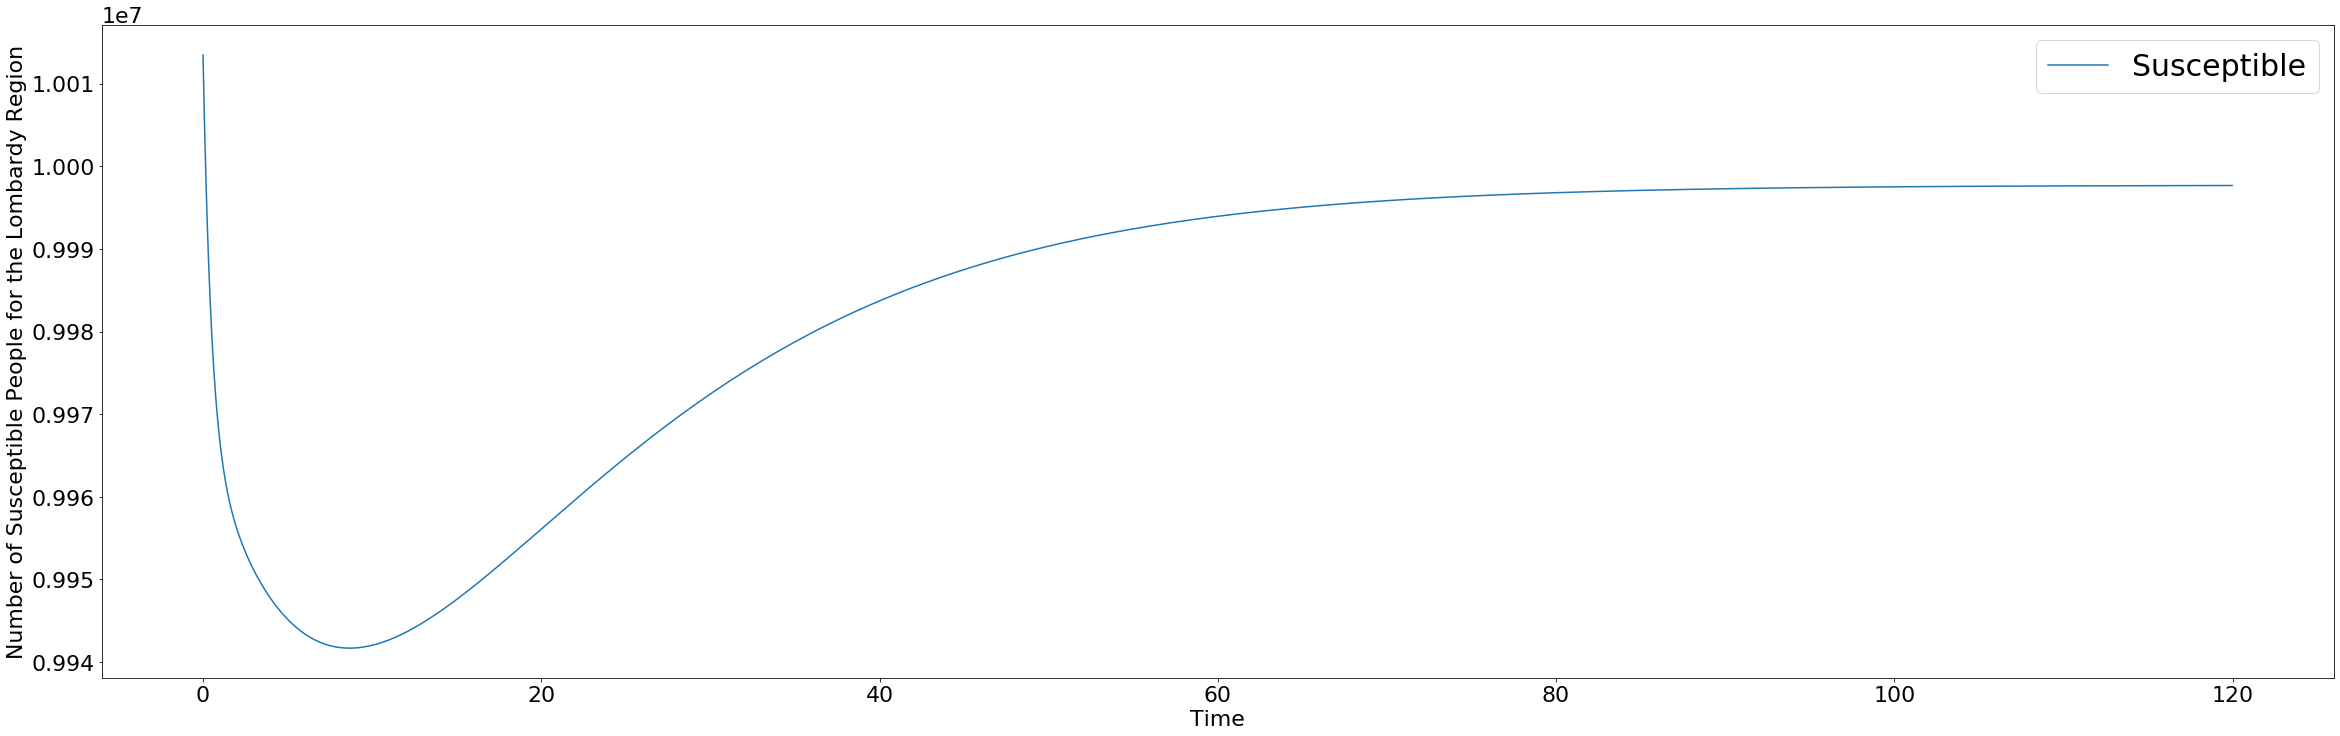

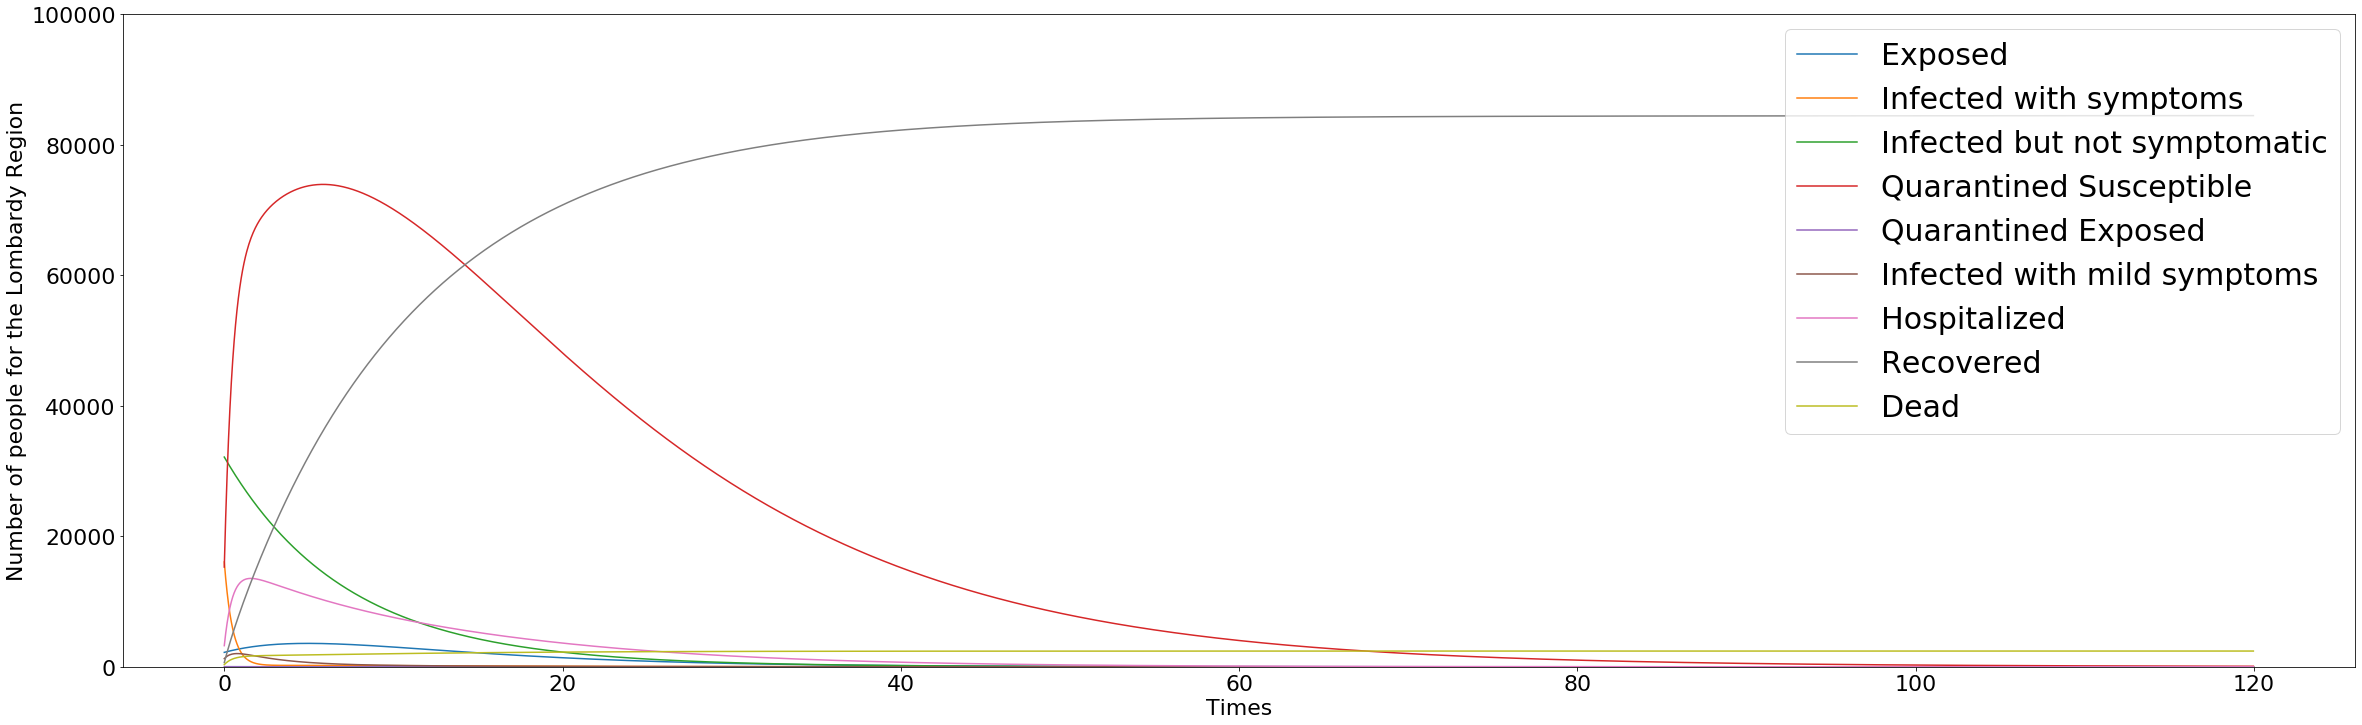

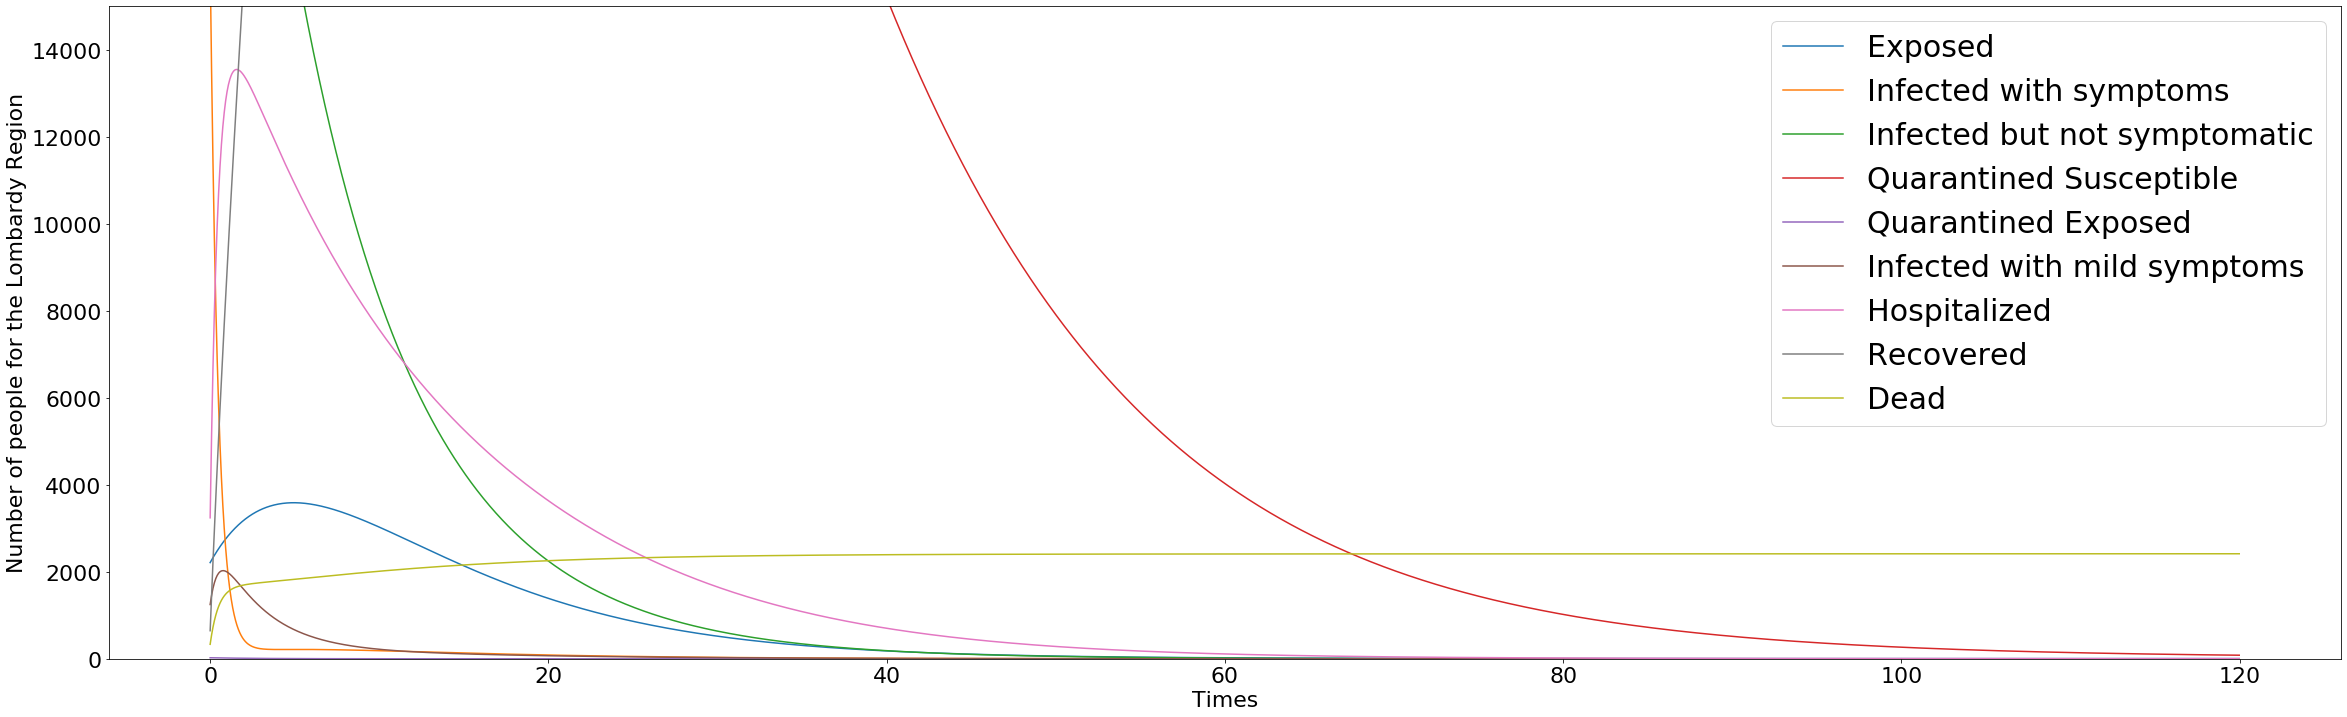

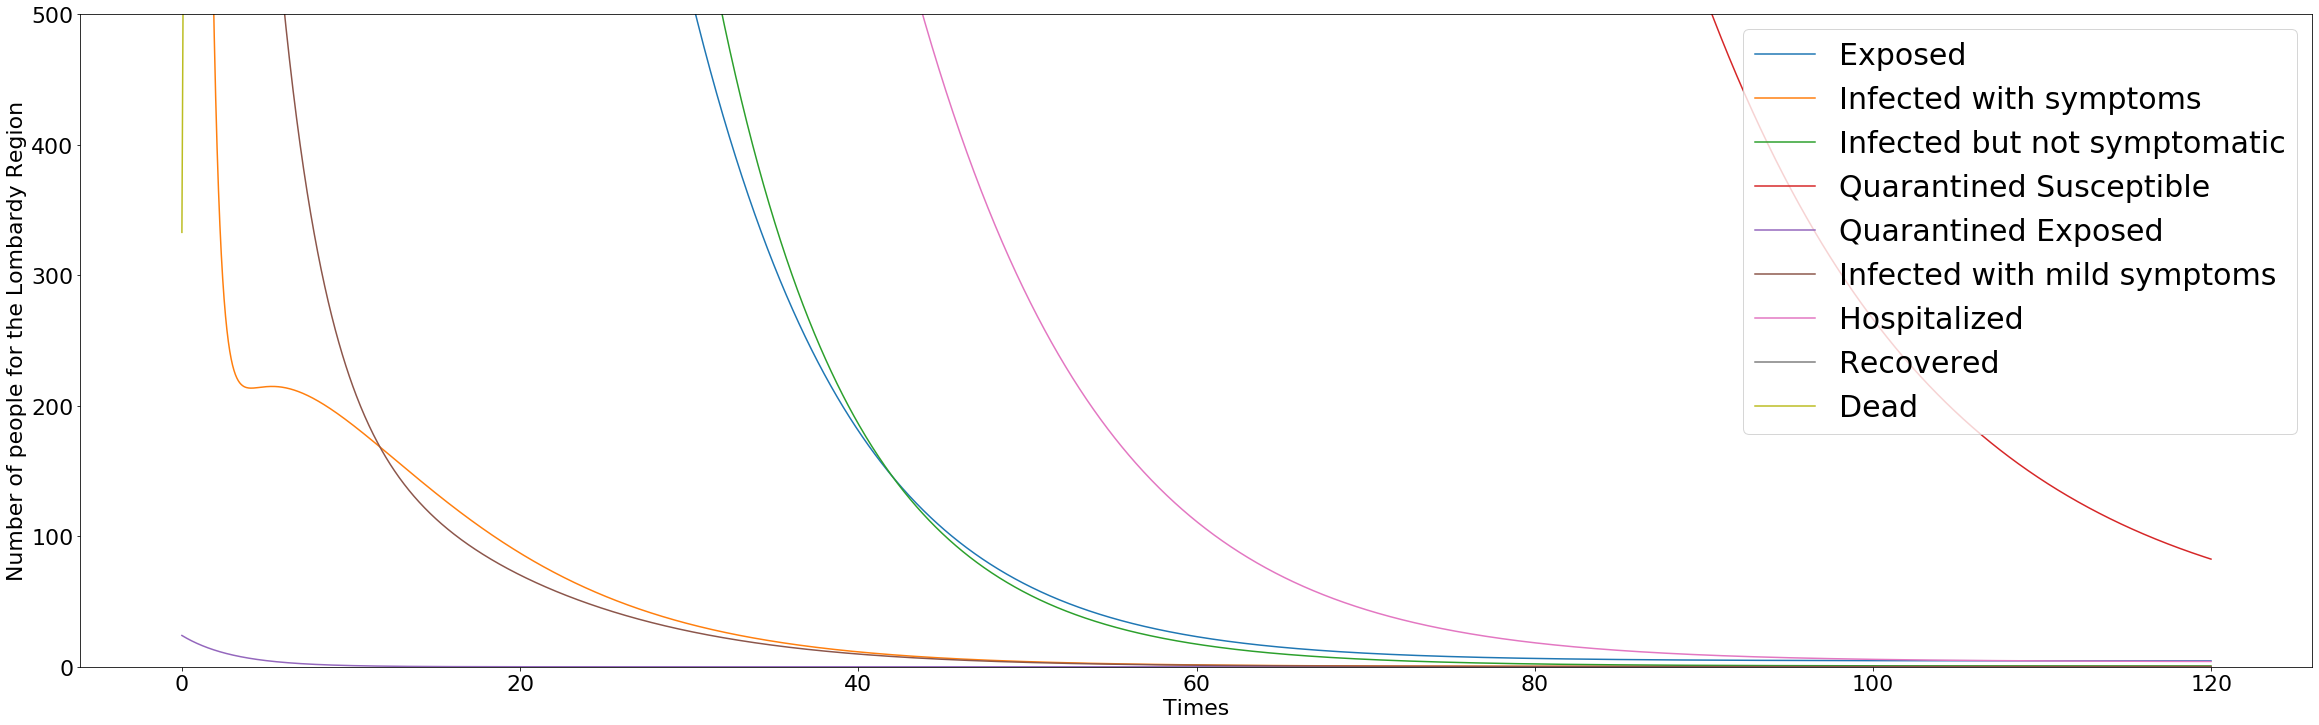

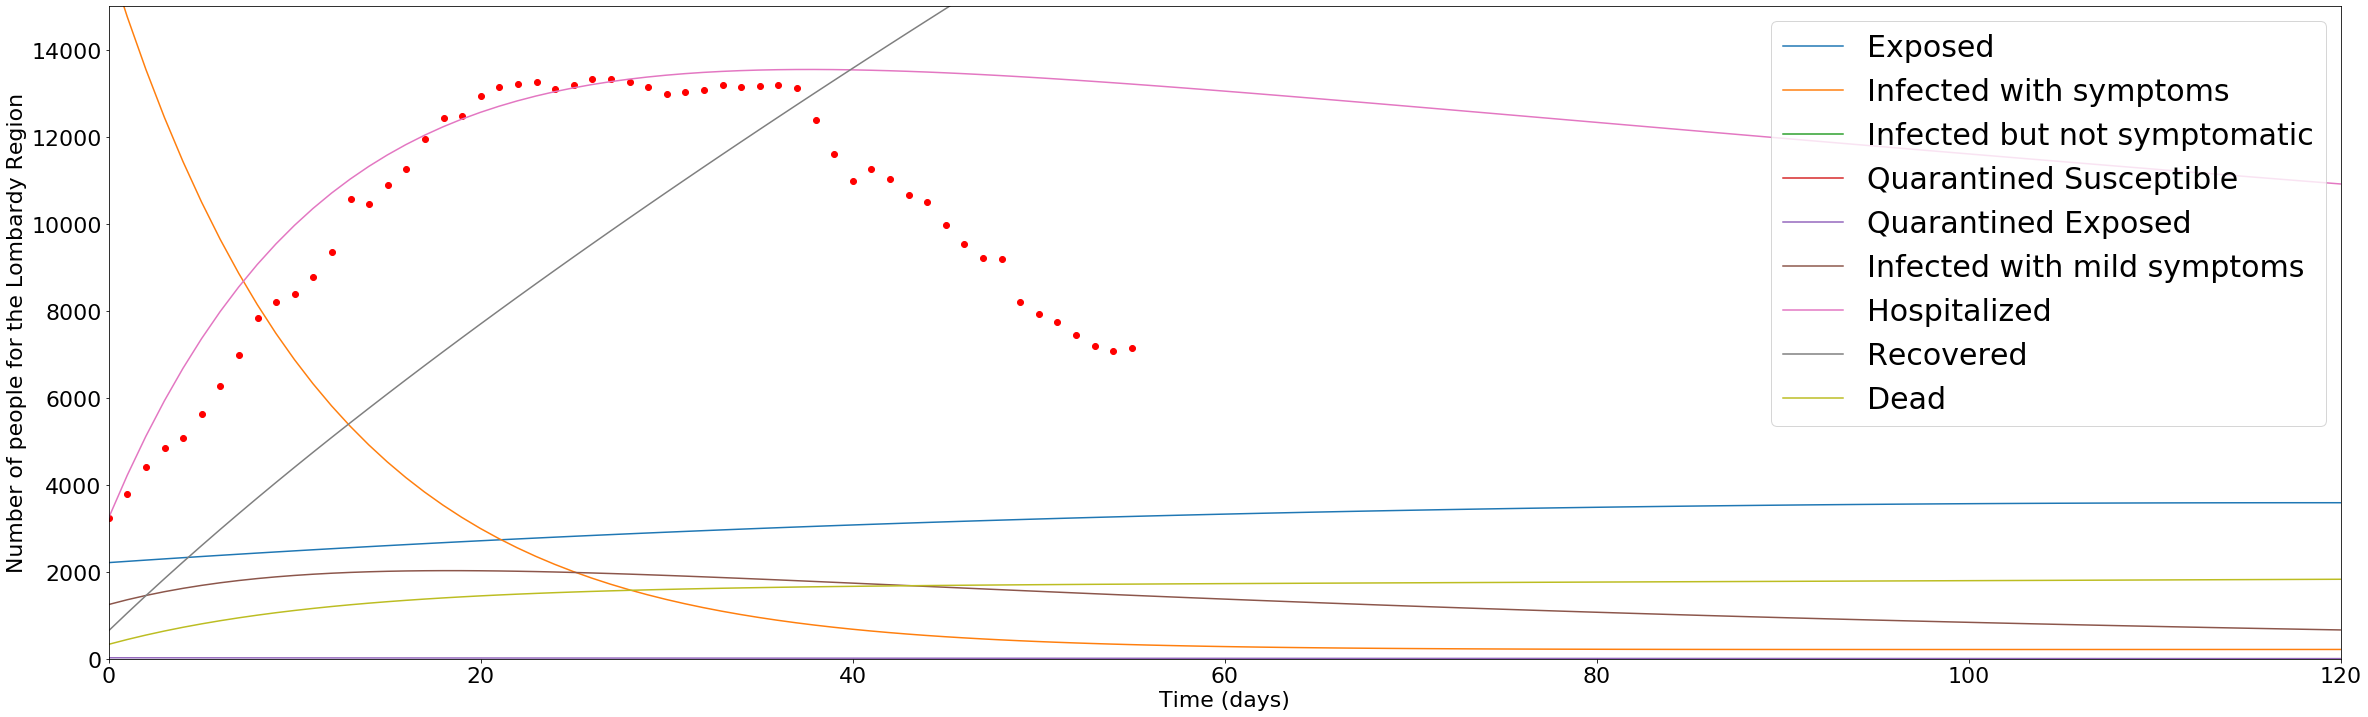

In [77]:
ic_L=np.zeros(8)
ic_L[0]=E_L
ic_L[1]=I_L
ic_L[2]=A_L
ic_L[3]=Sq_L
ic_L[4]=Eq_L
ic_L[5]=L_L
ic_L[6]=H_L
ic_L[7]=R_L

soln_L =odeint(SEIRpaper,ic_L,tvec,args=(c_L,delta_I_L,beta,q,sigma,l,rho,delta_q,gamma_I,gamma_A,gamma_H,alfa,theta,epsylon_I,epsylon_q,gamma_L,delta_L,N_L,D_L))
soln_L=np.hstack((soln_L, np.asarray(computeDead(soln_L,D_L,0.18/24)).reshape(-1,1)))
#soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))
#print(N-np.sum(soln,axis=1,keepdims=True)-D)

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(40,12))
#Stessa plot ma su scala logaritmica
#plt.subplot(1,2,1)
plt.plot(tvec,(N_L-D_L-np.sum(soln_L,axis=1,keepdims=True)))
plt.xlabel("Time")
plt.ylabel("Number of Susceptible People for the Lombardy Region")
plt.legend(["Susceptible"], prop={"size":30},loc="upper right")

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(tvec,soln_L)
plt.xlabel("Times")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,100000))

plt.figure(figsize=(40,12))
plt.plot(tvec,soln_L)
#plt.scatter(tvec_real_data, pc_data_L_clean['totale_ospedalizzati'], marker ='o', c = 'r')
plt.xlabel("Times")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,15000))

plt.figure(figsize=(40,12))
plt.plot(tvec,soln_L)
#plt.scatter(tvec_real_data, pc_data_L_clean['totale_ospedalizzati'], marker ='o', c = 'pink')
plt.xlabel("Times")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,500))

plt.figure(figsize=(40,12))
plt.plot(tvec*24,soln_L)
plt.scatter(tvec_real_data_L, pc_data_L_clean['totale_ospedalizzati'], marker ='o', c = 'r')
plt.xlabel("Time (days)")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,15000))
plt.xlim((0,120))

### Previsioni Lombardia

In [35]:
known_date_L = '21-03-2020'
index_L = date.index(datetime.strptime(known_date_L,FMT))*24
row_L = soln_L[index_L]
print("The forecast values on {} are:\n {} Susceptible,\n {} Exposed,\n {} Infected with symptoms,\n {} Infected but not symptomatic,\n {} Quarantined Susceptible,\n {} Quarantined Exposed,\n {} Infected with mild symptoms,\n {} Hospitalized,\n {} Recovered,\n {} Dead.".format(known_date_L,(N_L-D_L-np.sum(soln_L,axis=1,keepdims=True)[index_L][0]),row_L[0],row_L[1],row_L[2],row_L[3],row_L[4],row_L[5],row_L[6],row_L[7],row_L[8]))


The forecast values on 21-03-2020 are:
 9943599.098664684 Susceptible,
 2674.25483678761 Exposed,
 165.58783423626795 Infected with symptoms,
 6371.615097354171 Infected but not symptomatic,
 66483.78961590306 Quarantined Susceptible,
 0.4838693462240041 Quarantined Exposed,
 162.30858605605576 Infected with mild symptoms,
 6558.109756583166 Hospitalized,
 56596.09808765829 Recovered,
 2076.6536513901033 Dead.


### Introduzione di misure di contenimento per la Lombardia

Variando il valore beta (che indica il tasso con cui le persone infette contagiano i suscettibili) e di q (tasso di quarantena degli individui esposti) pesandoli, vogliamo dimostrare come sia possibile visualizzare l'andamento che si avrebbe simulando un contenimento.

In [36]:
betaSlow=beta*5
qSlow=q*0.5

(0, 500)

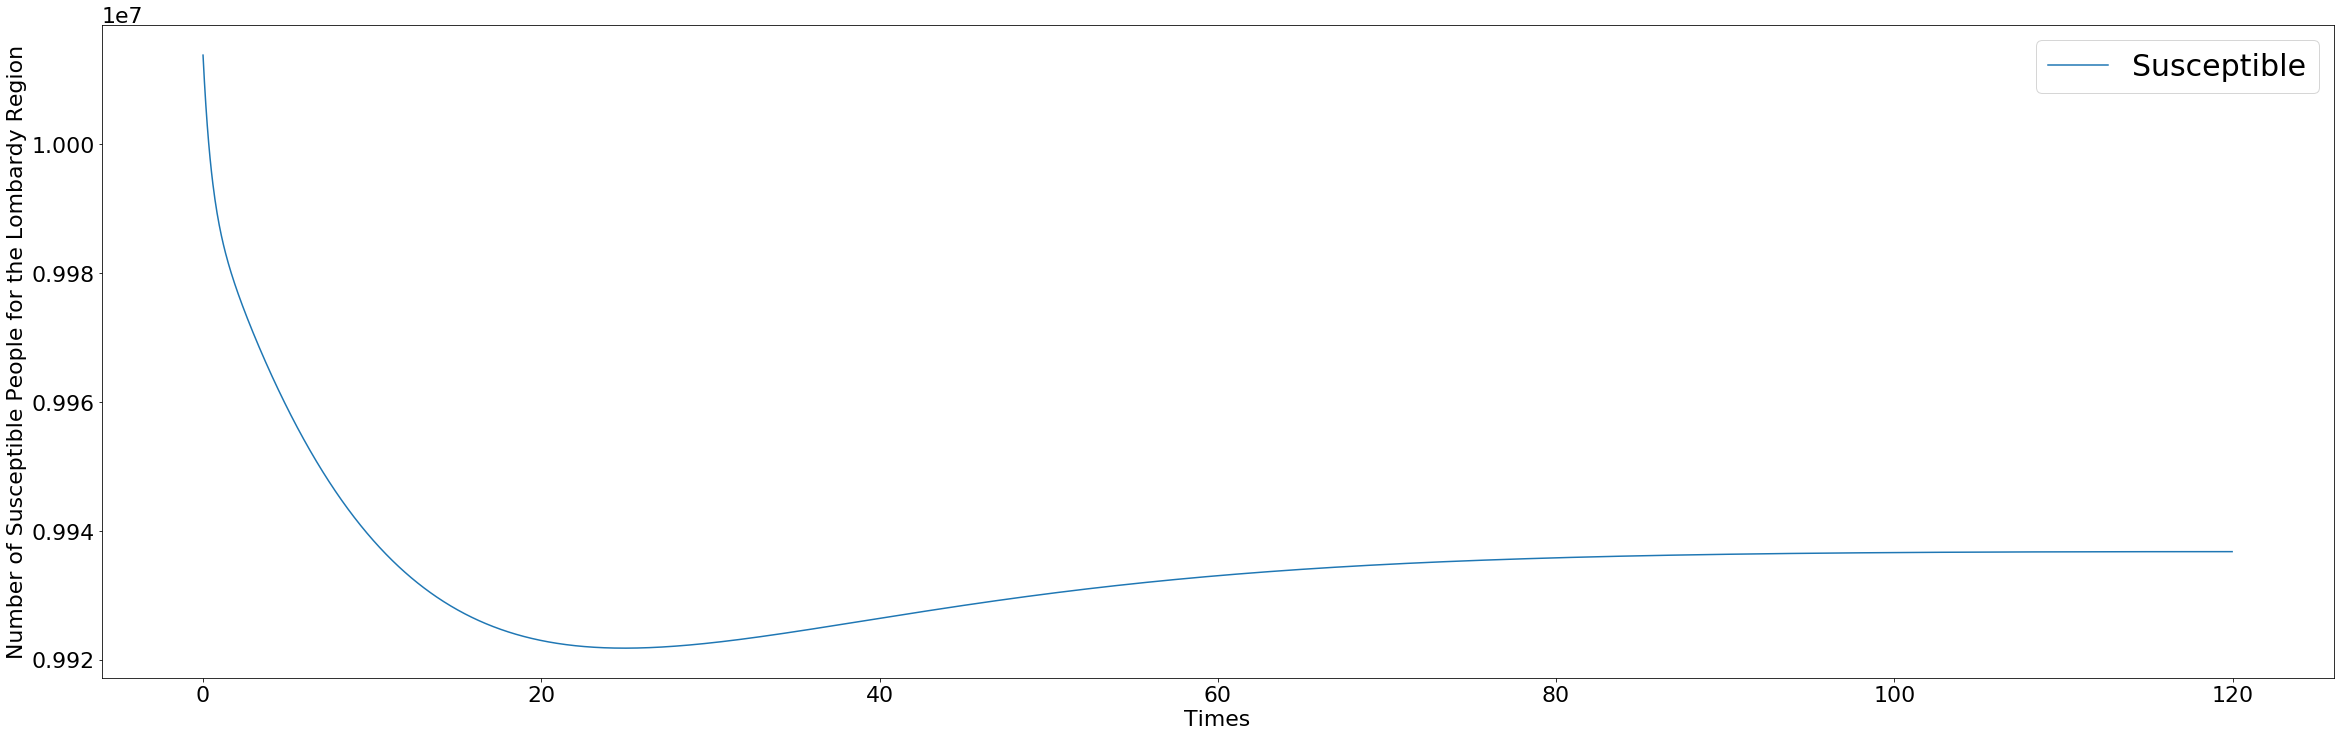

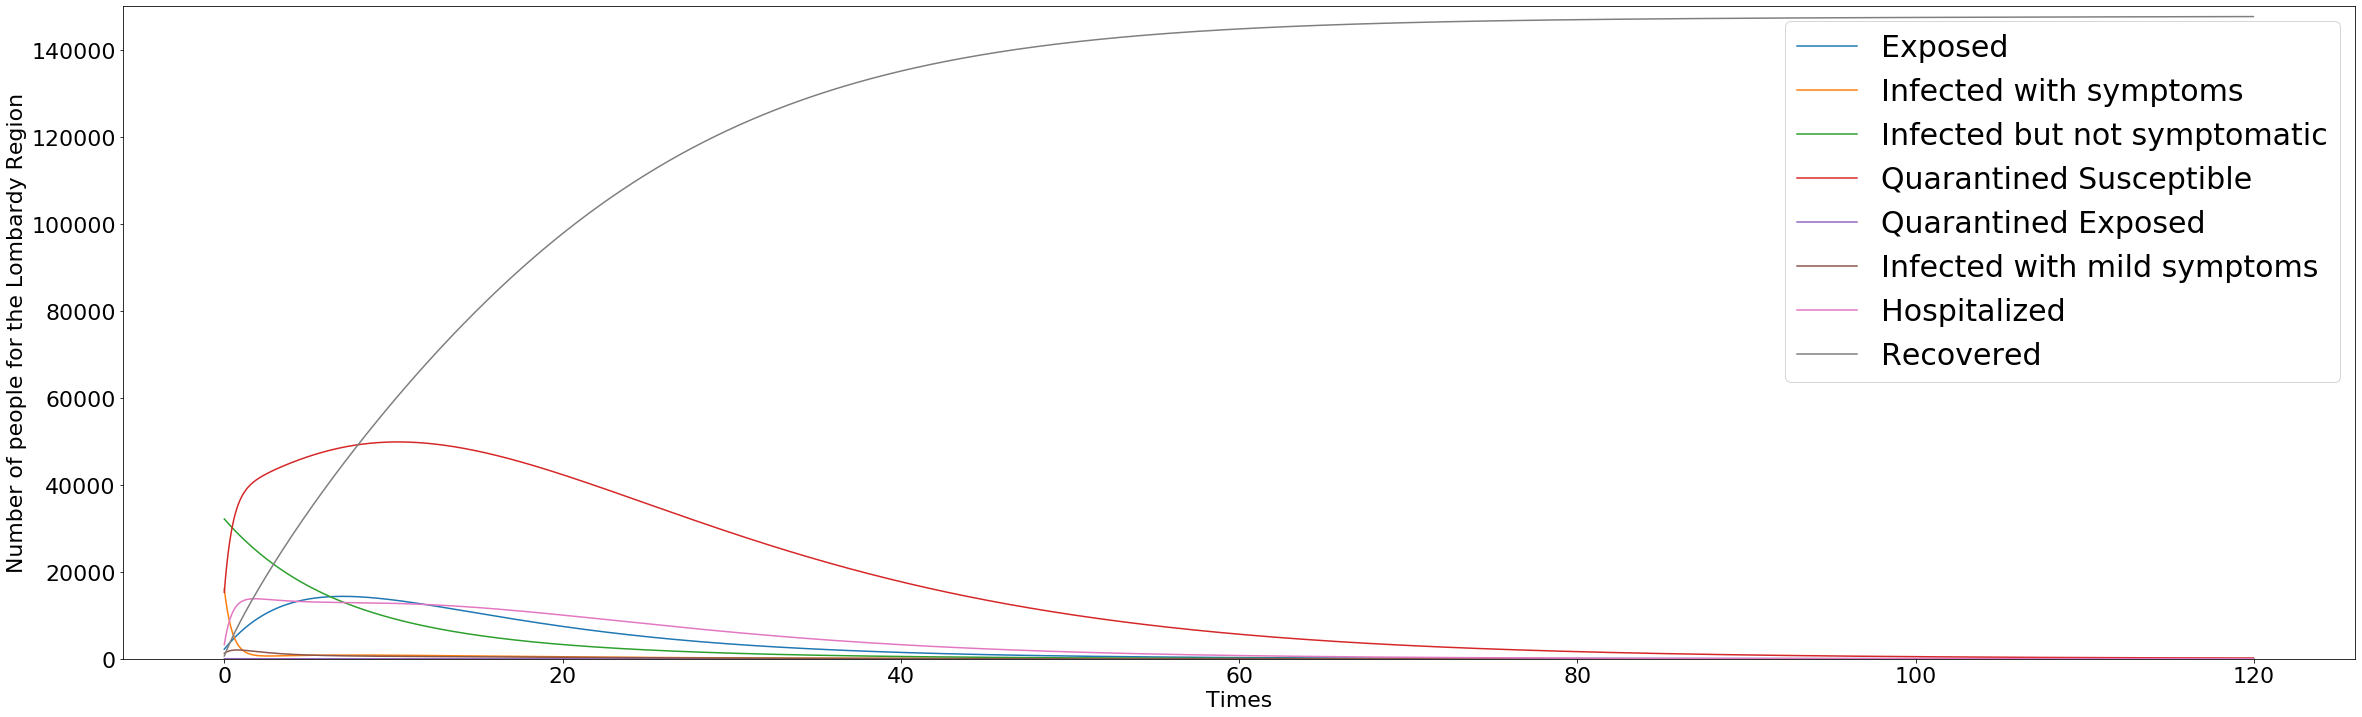

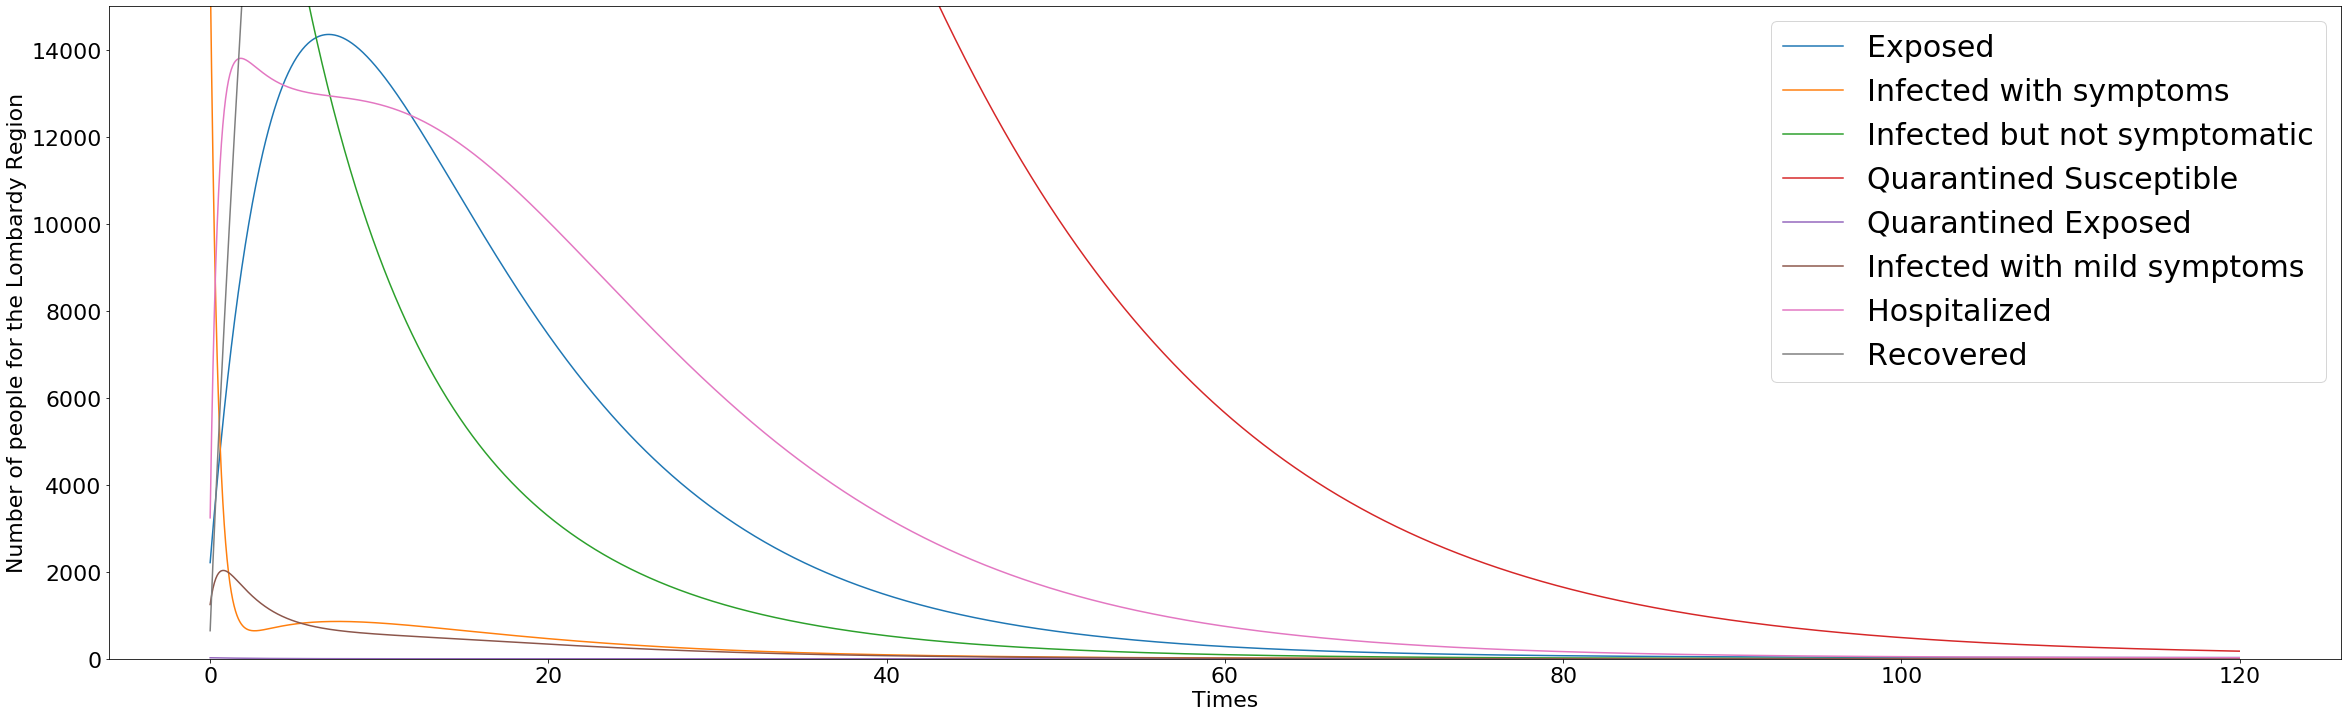

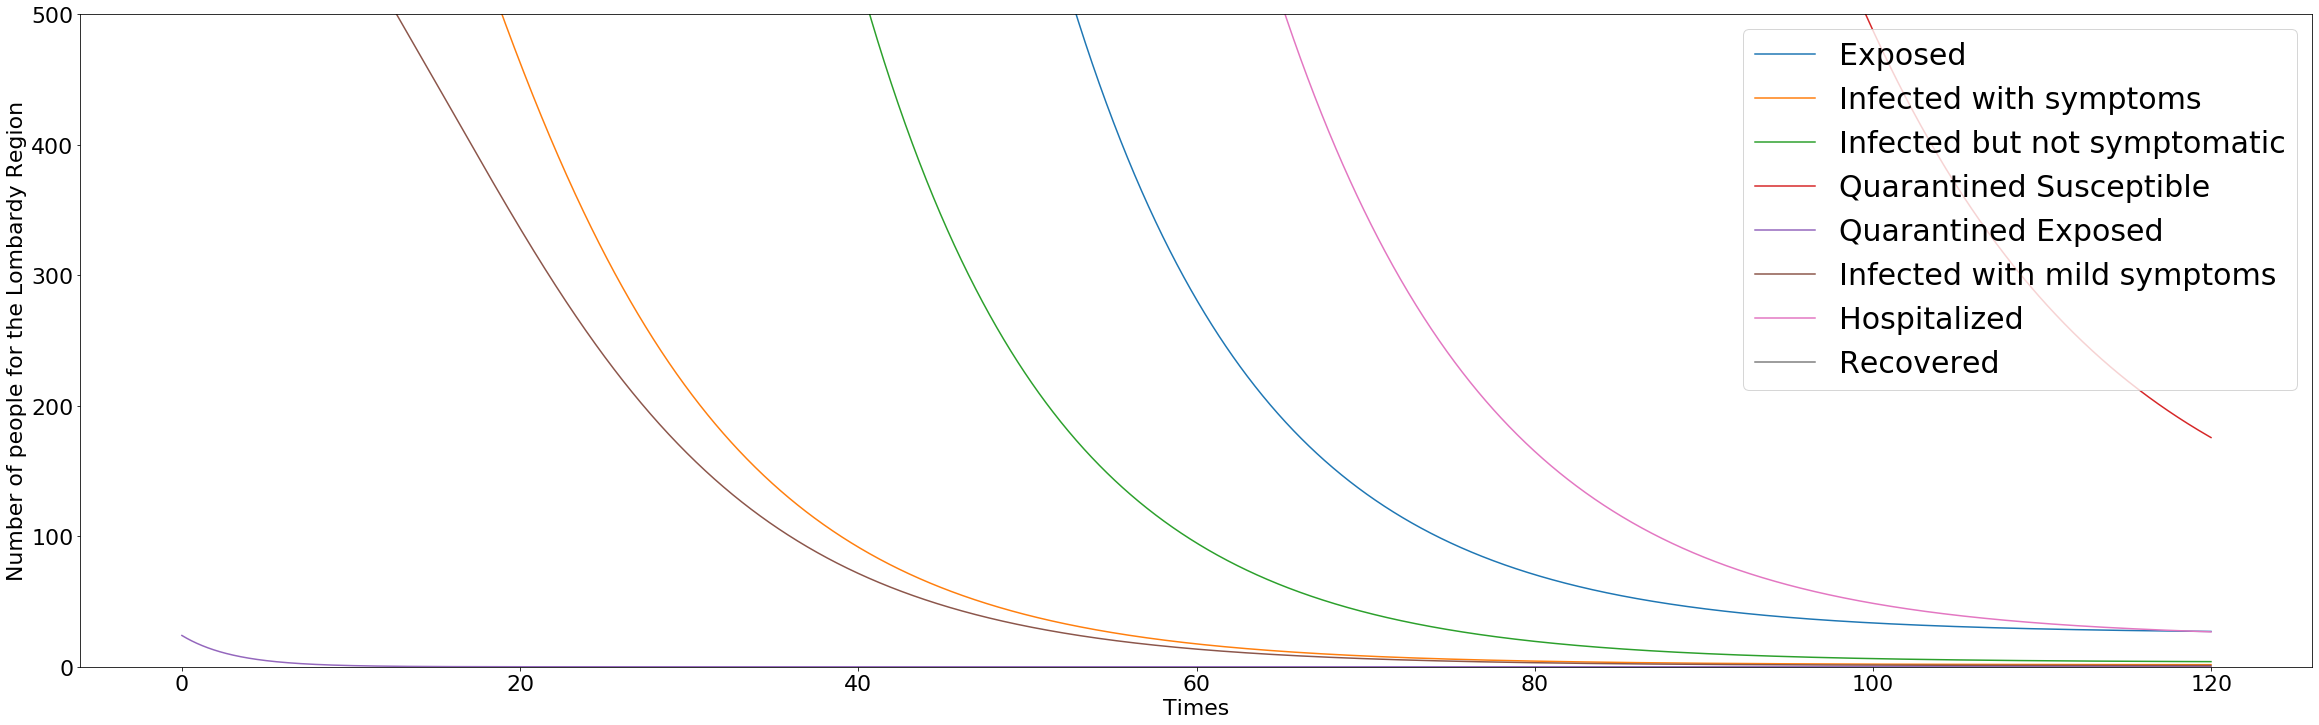

In [37]:
ic_L_Slow=np.zeros(8)
ic_L_Slow[0]=E_L
ic_L_Slow[1]=I_L
ic_L_Slow[2]=A_L
ic_L_Slow[3]=Sq_L
ic_L_Slow[4]=Eq_L
ic_L_Slow[5]=L_L
ic_L_Slow[6]=H_L
ic_L_Slow[7]=R_L

soln_L_Slow =odeint(SEIRpaper,ic_L_Slow,tvec,args=(c_L,delta_I_L,betaSlow,qSlow,sigma,l,rho,delta_q,gamma_I,gamma_A,gamma_H,alfa,theta,epsylon_I,epsylon_q,gamma_L,delta_L,N_L,D_L))
#soln_L=np.hstack((soln_L, np.asarray(computeDead(soln_L,D_L)).reshape(-1,1)))
#soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))
#print(N-np.sum(soln,axis=1,keepdims=True)-D)

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(40,12))
#Stessa plot ma su scala logaritmica
#plt.subplot(1,2,1)
plt.plot(tvec,(N_L-D_L-np.sum(soln_L_Slow,axis=1,keepdims=True)))
plt.xlabel("Times")
plt.ylabel("Number of Susceptible People for the Lombardy Region")
plt.legend(["Susceptible"], prop={"size":30},loc="upper right")

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(tvec,soln_L_Slow)
plt.xlabel("Times")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered"], prop={"size":30},loc="upper right")
plt.ylim((0,150000))

plt.figure(figsize=(40,12))
plt.plot(tvec,soln_L_Slow)
#plt.scatter(tvec_real_data, pc_data_L_clean['totale_ospedalizzati'], marker ='o', c = 'pink')
plt.xlabel("Times")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered"], prop={"size":30},loc="upper right")
plt.ylim((0,15000))

plt.figure(figsize=(40,12))
plt.plot(tvec,soln_L_Slow)
#plt.scatter(tvec_real_data, pc_data_L_clean['totale_ospedalizzati'], marker ='o', c = 'pink')
plt.xlabel("Times")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered"], prop={"size":30},loc="upper right")
plt.ylim((0,500))

Da ciò è possibile vedere come il numero di infetti si riduca di molto, ma possiamo anche vedere come i tempi di risoluzione della pandemia si allunghino altrettanto.
### OSSERVAZIONE
Adottare misure contenitive permette una riduzione della mortalità e degli infetti con tempi più lunghi, evento che non ci sarebbe con un decorso normale della pandemia, che ridurrebbe i tempi al raggiungimento dell'immunità di mandria aumentando esponenzialmente mortalità ed infezioni.

## Emilia Romagna

In [38]:
pc_data_E = pc_data.loc[pc_data['denominazione_regione'] == 'Emilia-Romagna']
pc_data_E = pc_data_E.drop(pc_data_E.columns[[1,2,4,5,17,18,19]], axis=1).iloc[14:45]
pc_data_E_clean = pc_data_E.reset_index(drop=True)
tvec_real_data_E=np.arange(0,len(pc_data_E_clean['data']))

In [39]:
#Dati al 9 Marzo 2020

N_E = 4468023 # residenti al 31 Ottobre 2019
D_E = 70 #Morti 
H_E = 666 #ospedalizzati
L_E = 620 #infetti isolati 
I_E = 4520 # infetti undected e sintomatici 
K_I_E = H_E+L_E+D_E #infetti rilevati
A_E = 9040 #infetti undected e asintomatici
U_I_E = A_E+I_E #infetti undected
T_E = 4906 #Tests
Q_E = 3550 #persone in quarantena 
Eq_E = 6 #esposti in quarantena
Sq_E = 3544  # suscettibili in quarantena
E_E = 513 #esposti non conosciuti 
R_E = 30 #ricovertati
S_E = 4449014 #suscettibili

Nel nostro caso abbiamo assunto (come esposto nel paper) un tasso di contatto c=7.4 per la Lombardia, ed un tasso di diagnosi di 2.5 (tale tasso non è stato riportato nel paper).

In [40]:
c_E=7.4
delta_I_E=delta_I(tmax,0.13266,0.3283,(1/0.3))
print(delta_I_E)

3.3333333333333335


(0, 60)

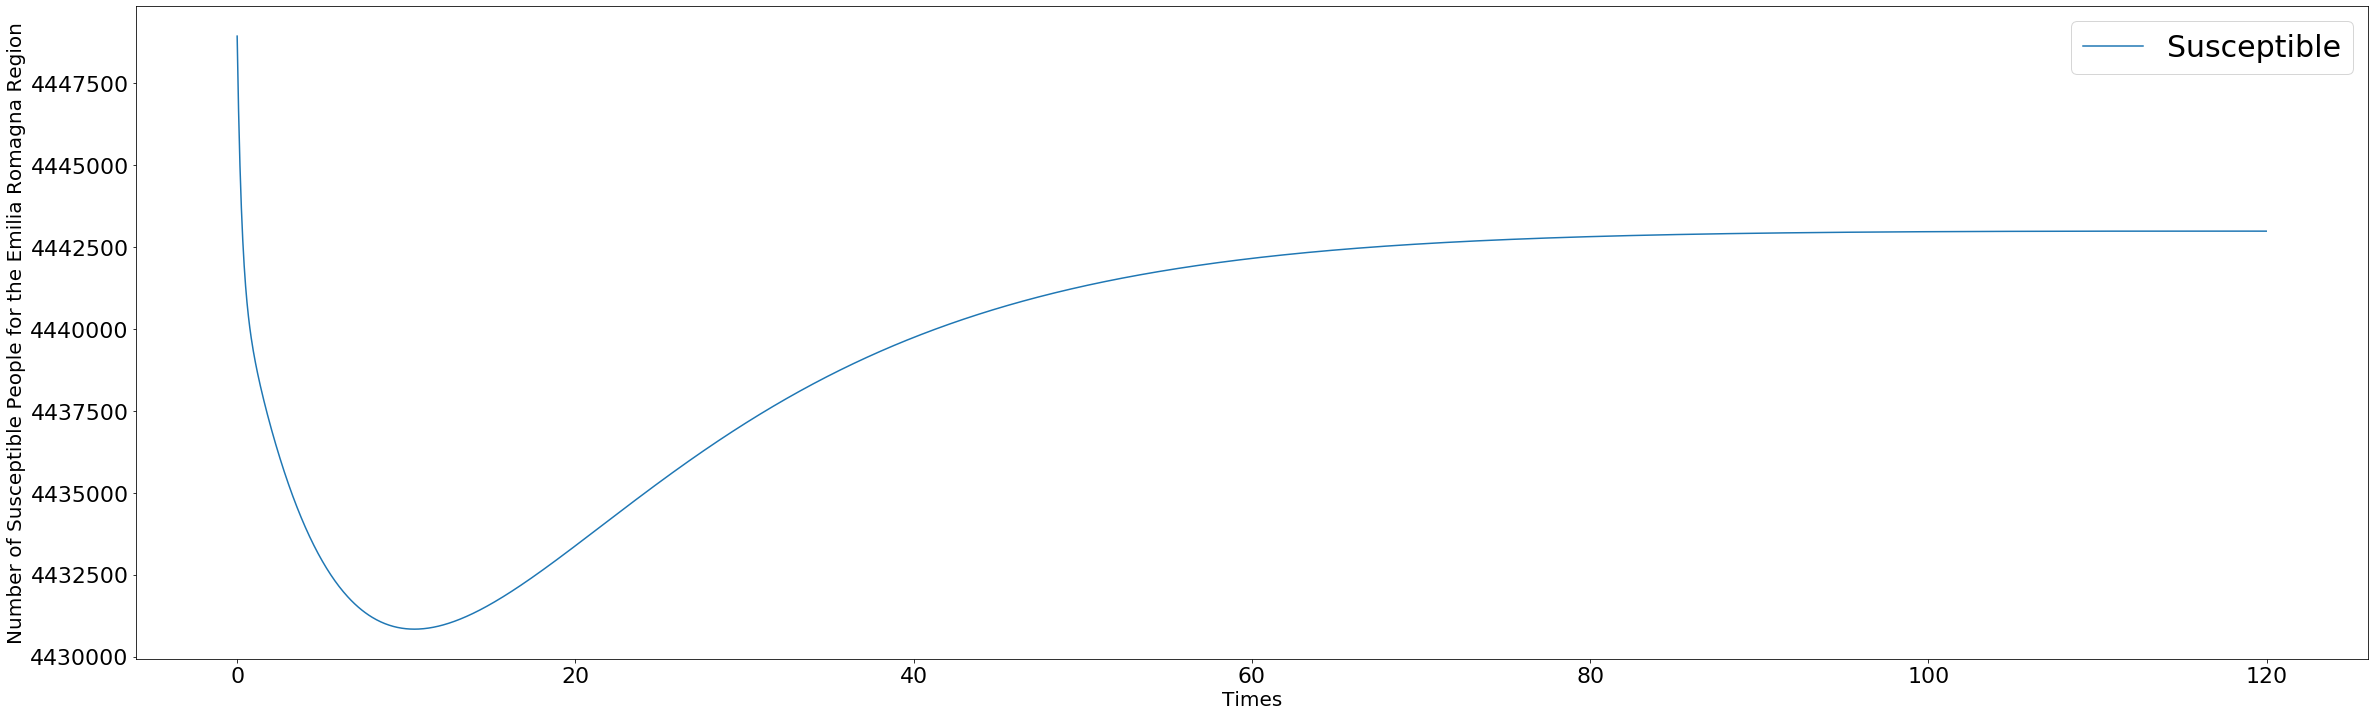

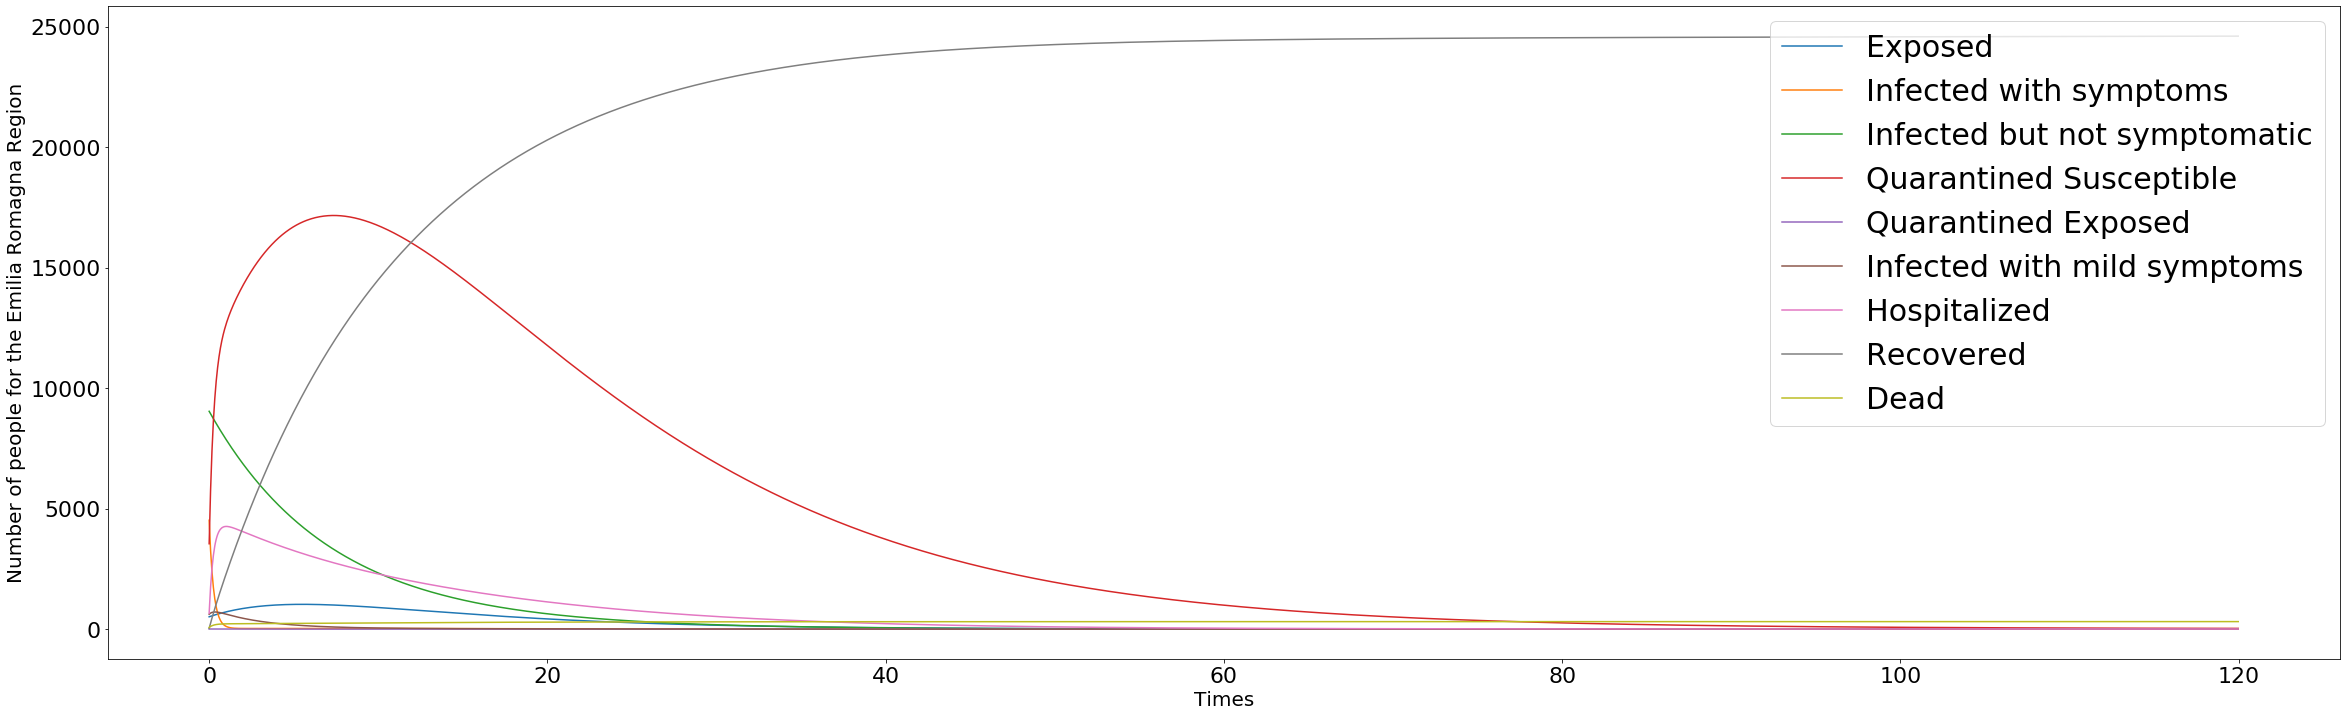

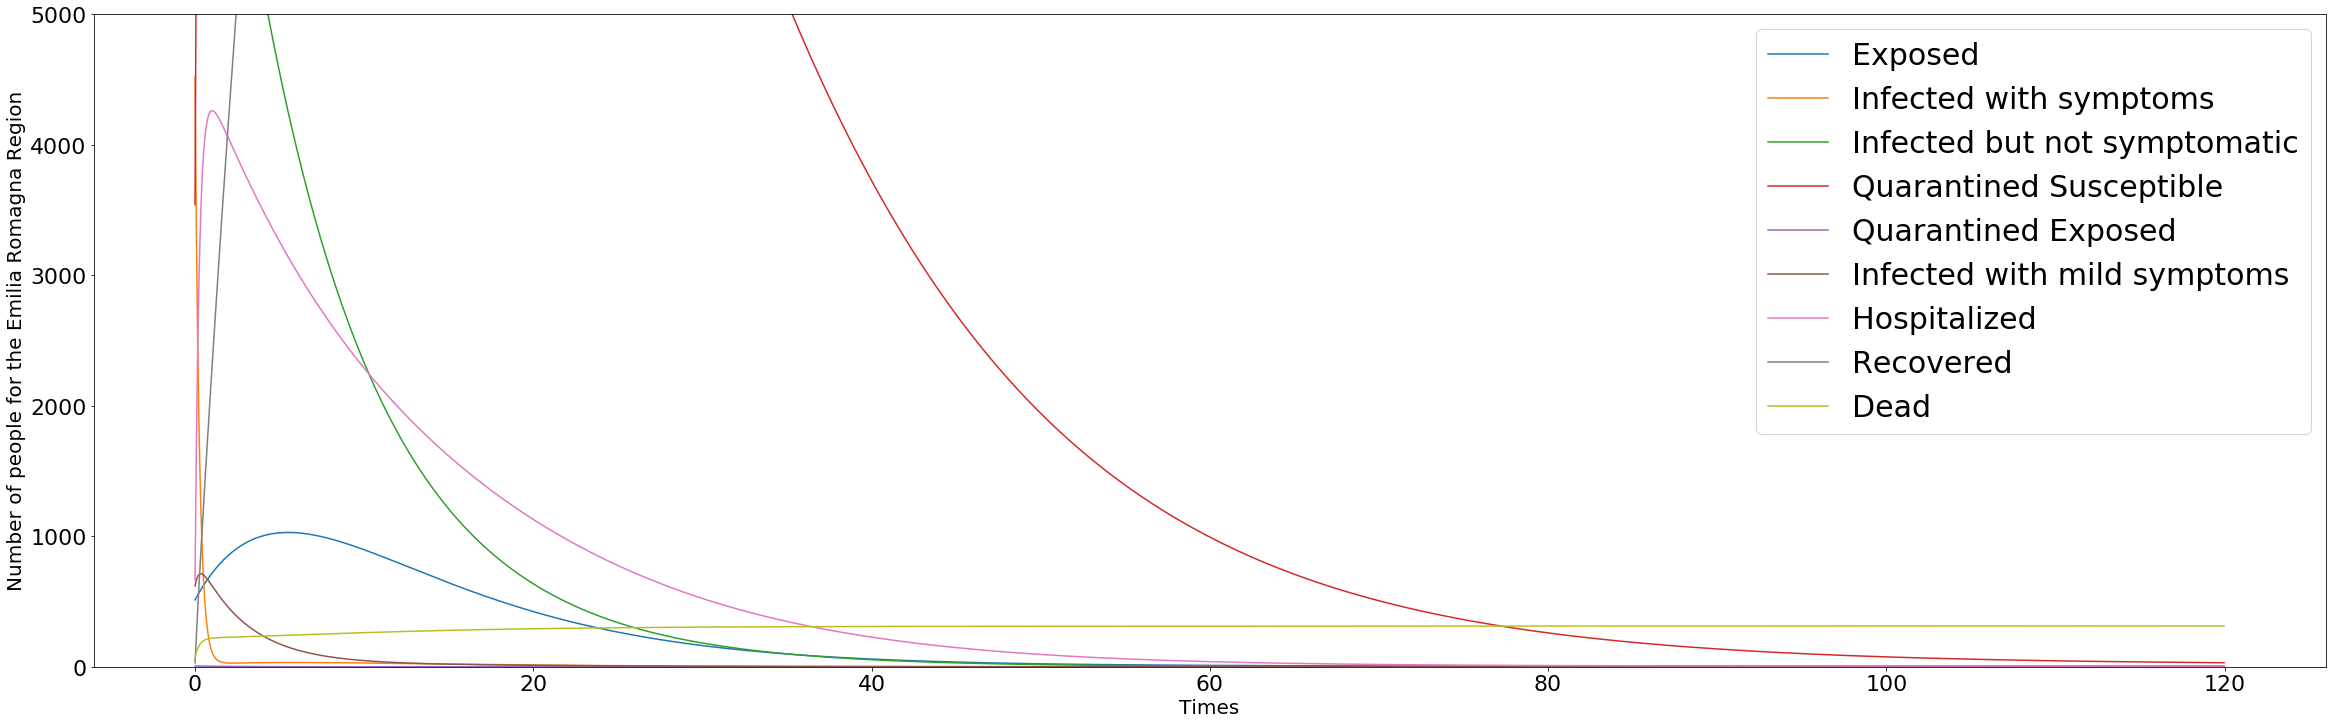

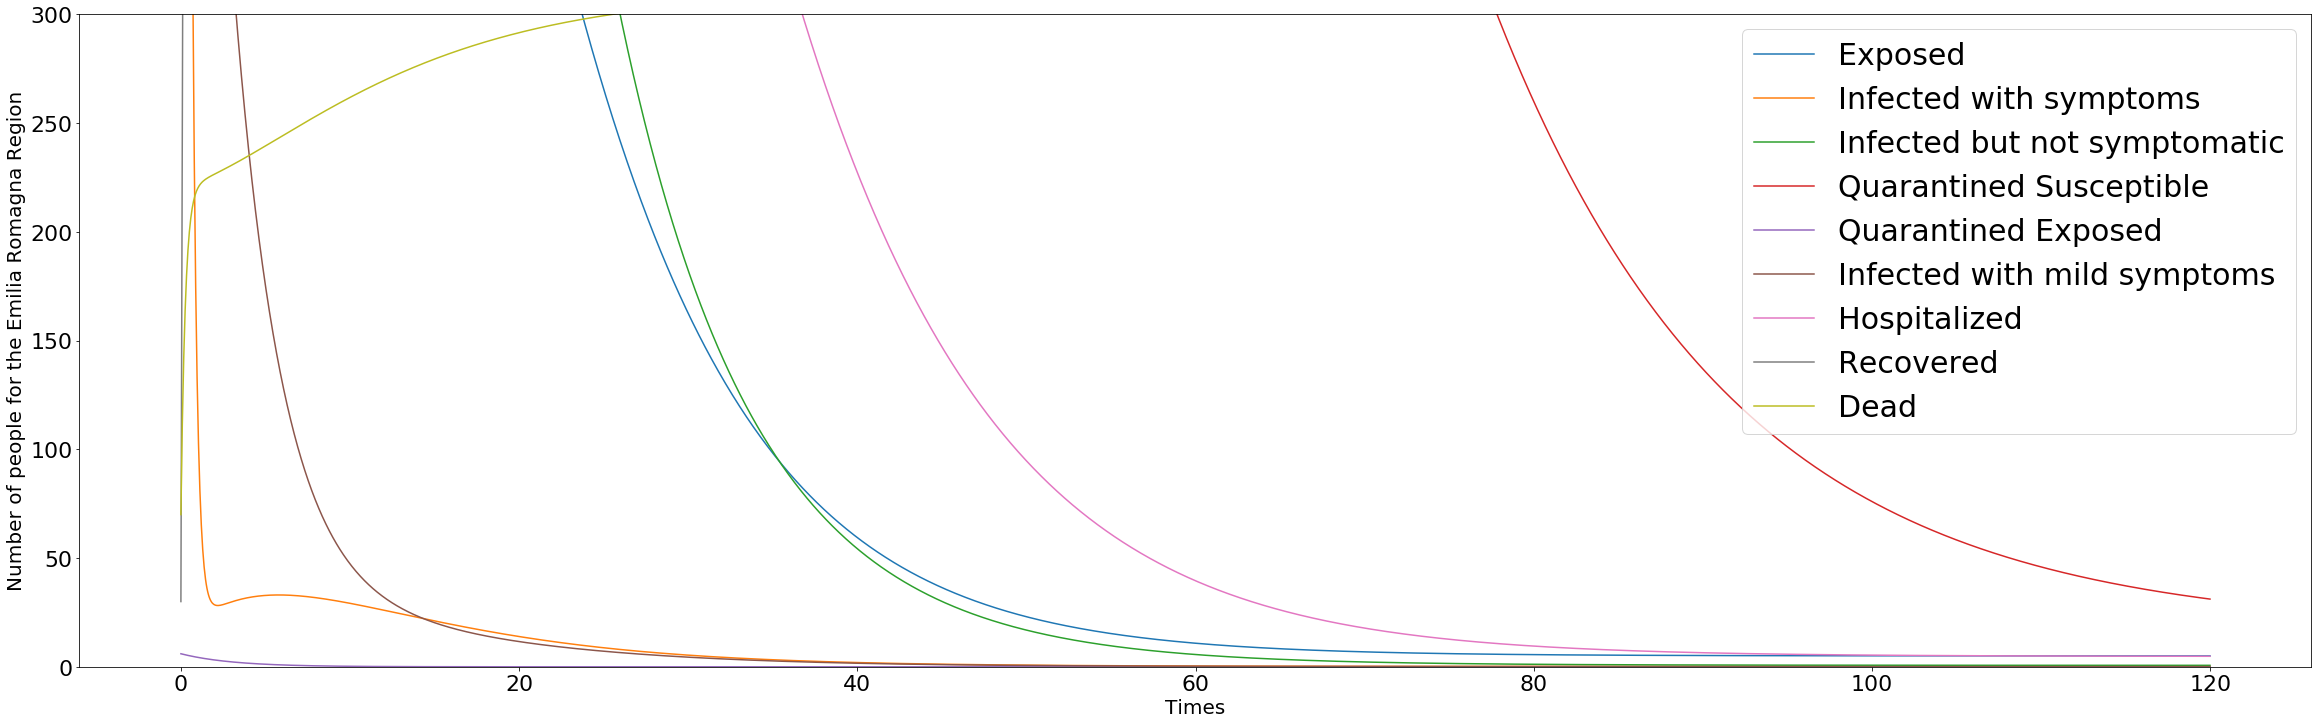

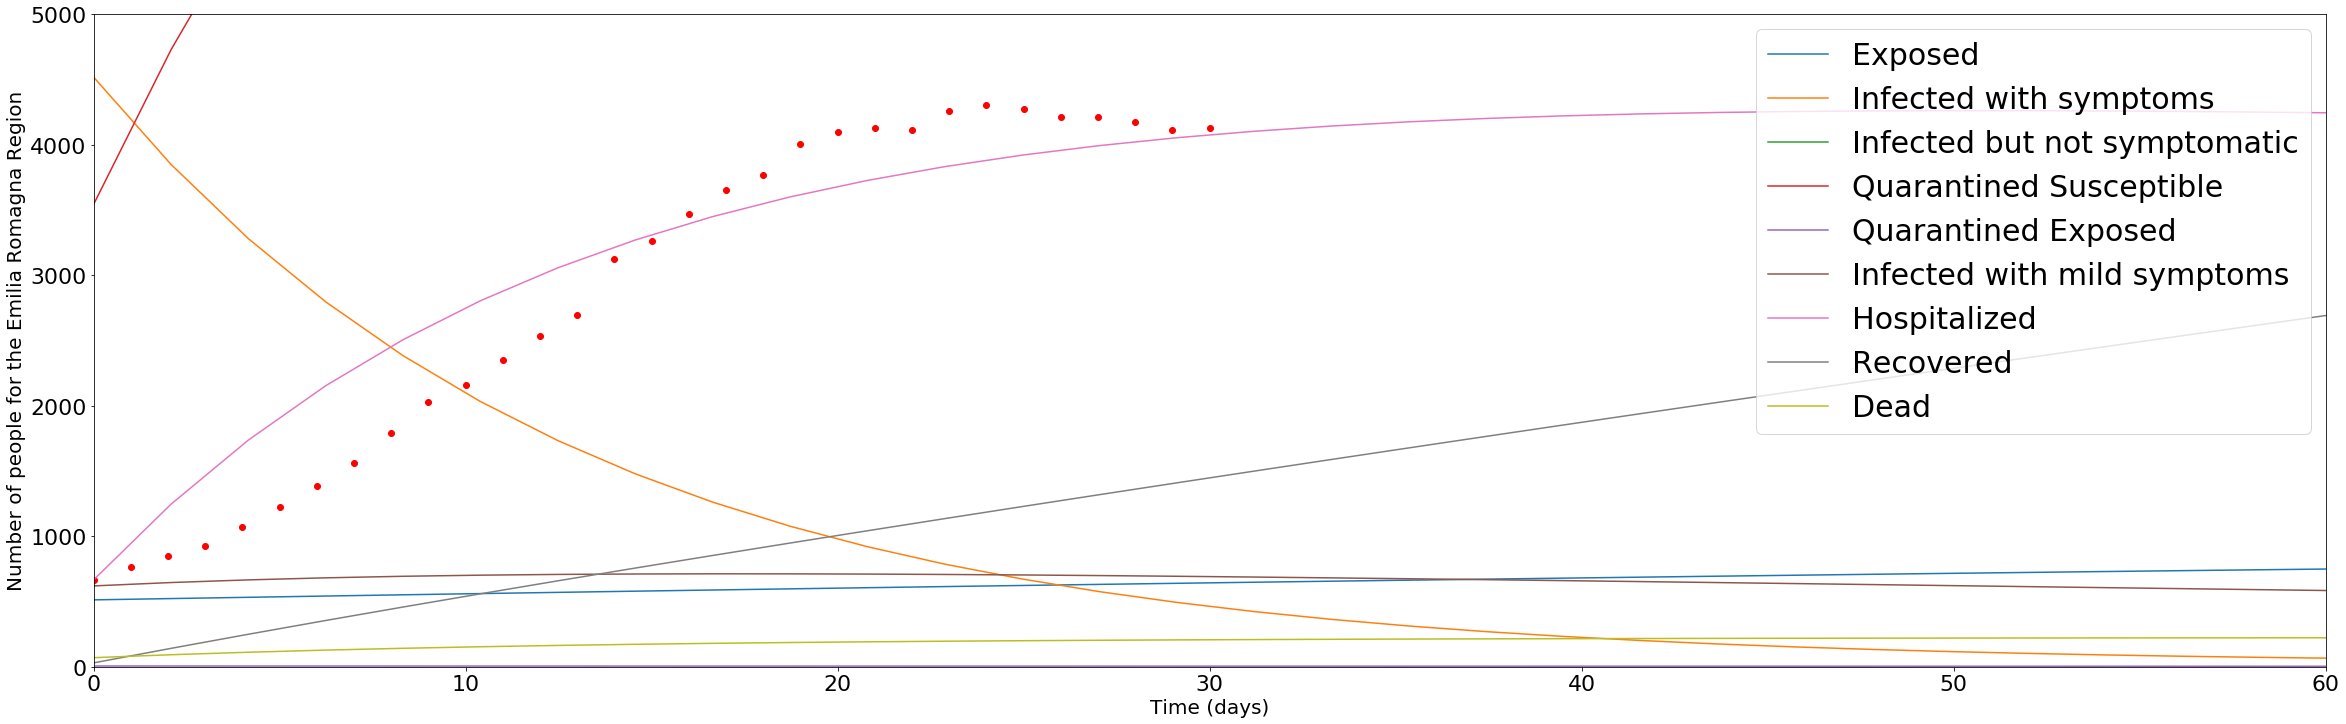

In [59]:
ic_E=np.zeros(8) # condizioni iniziali
ic_E[0]=E_E
ic_E[1]=I_E
ic_E[2]=A_E
ic_E[3]=Sq_E
ic_E[4]=Eq_E
ic_E[5]=L_E
ic_E[6]=H_E
ic_E[7]=R_E

# scipy odeint Integrate a system of ordinary differential equations.
soln_E=odeint(SEIRpaper,ic_E,tvec,args=(c_E,delta_I_E,beta,q,sigma,l,rho,delta_q,gamma_I,gamma_A,gamma_H,alfa,theta,epsylon_I,epsylon_q,gamma_L,delta_L,N_E,D_E))
soln_E=np.hstack((soln_E, np.asarray(computeDead(soln_E,D_E,0.14/24)).reshape(-1,1)))

#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(40,12))
plt.plot(tvec,(N_E-D_E-np.sum(soln_E,axis=1,keepdims=True))) #N -D (perché son parametri costanti, non abbiamo eq sui morti) - soluzione degli esposti
plt.xlabel("Times", fontsize = 20)
plt.ylabel("Number of Susceptible People for the Emilia Romagna Region" , fontsize = 20)
plt.legend(["Susceptible"], prop={"size":30},loc="upper right")

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(tvec,soln_E)
plt.xlabel("Times", fontsize = 20)
plt.ylabel("Number of people for the Emilia Romagna Region", fontsize = 20)
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
#plt.ylim((0,100000))


plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(tvec,soln_E)
#plt.scatter(tvec_real_data, pc_data_E_clean['totale_ospedalizzati'], marker ='o', c = 'red')
plt.ylim(0,30000)
plt.xlabel("Times", fontsize = 20)
plt.ylabel("Number of people for the Emilia Romagna Region", fontsize = 20)
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,5000))

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(tvec,soln_E)
#plt.scatter(tvec_real_data, pc_data_E_clean['totale_ospedalizzati'], marker ='o', c = 'pink', label="Real Hospitalized Data")
plt.ylim(0,30000)
plt.xlabel("Times", fontsize = 20)
plt.ylabel("Number of people for the Emilia Romagna Region", fontsize = 20)
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,300))

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(tvec*50,soln_E)
plt.scatter(tvec_real_data_E, pc_data_E_clean['totale_ospedalizzati'], marker ='o', c = 'red')
plt.ylim(0,30000)
plt.xlabel("Time (days)", fontsize = 20)
plt.ylabel("Number of people for the Emilia Romagna Region", fontsize = 20)
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered","Dead"], prop={"size":30},loc="upper right")
plt.ylim((0,5000))
plt.xlim((0,60))

### Previsioni Emilia

In [42]:
known_date_E = '21-03-2020'
index_E = date.index(datetime.strptime(known_date_E,FMT))*24
row_E = soln_E[index_E]
print("The forecast values on {} are:\n {} Susceptible,\n {} Exposed,\n {} Infected with symptoms,\n {} Infected but not symptomatic,\n {} Quarantined Susceptible,\n {} Quarantined Exposed,\n {} Infected with mild symptoms,\n {} Hospitalized,\n {} Recovered,\n {} Dead.".format(known_date_E,(N_E-D_E-np.sum(soln_E,axis=1,keepdims=True)[index_E][0]),row_E[0],row_E[1],row_E[2],row_E[3],row_E[4],row_E[5],row_E[6],row_E[7],row_E[8]))

The forecast values on 21-03-2020 are:
 4430939.943673024 Susceptible,
 798.4856633095765 Exposed,
 26.062915594140406 Infected with symptoms,
 1794.2286320429657 Infected but not symptomatic,
 16020.135098605033 Quarantined Susceptible,
 0.12097037758193206 Quarantined Exposed,
 32.10448974013011 Infected with mild symptoms,
 1994.7465287494667 Hospitalized,
 16077.63724265388 Recovered,
 269.53478590350653 Dead.


### CONCLUSIONE:
In questo modello lo studio dell'andamento della pandemia è stato espresso in termini di numero di contatti giornalieri c in una popolazione chiusa; questa tipologia di analisi semplifica di molto l'analisi tramite rapporto riproduttivo di base R0 (=indice di morbilità {include la risposta individuale specifica al virus e alle circostanze dell'infezione}) della diffusione della malattia, che sarebbe risultata molto complessa visto il grande numero di compartimenti.

## Integrazione con i dati di mobilità del modello per la Lombardia

Per integrare i dati di mobilità con il modello nella maniera più corretta possibile, bisognerebbe abbinare le Markov Chain Monte Carlo che rappresentano un processo casuale attraverso il quale un sistema passa da uno stato all'altro all'interno di uno spazio degli stati. Sono privi di memoria, nel senso che i possibili stati in cui il sistema può passare al momento dipendono solo dallo stato attuale del sistema, non da come è arrivato lì (Un esempio classico di un processo a catena di Markov è una partita di baseball. Se al momento t non hai nessuno sulla base e due fuori, ci sono solo 5 possibili esiti al prossimo at-bat; persona al primo posto, persona al secondo, persona al terzo, corsa a casa o fuori. L'elenco dei potenziali stati di transizione non dipende da ciò che è accaduto prima nel gioco che ha portato al particolare stato attuale. Un esempio di Non Markov Chain sono i terremoti; la probabilità che ci sia un terremoto in un luogo dipende molto da quando si sono verificati terremoti precedenti. Il sistema NON è privo di memoria e quindi NON è un processo Markov Chain Monte Carlo). 

### Algoritmo Markov Chain Monte Carlo
La codifica di un modello compartimentale stocastico MCMC consiste nei seguenti passaggi:
<br>1)Inizializzo con i compartimenti in alcune condizioni iniziali;
<br>2)Determino tutti i possibili cambiamenti di +1 o -1 che possono verificarsi nel numero di individui nei compartimenti;
<br>3)In base allo stato corrente del sistema, determinare la fase temporale, delta_t, necessaria affinché un solo individuo cambi i compartimenti dell'intero sistema, in media;
<br>4)Determinare il numero medio di volte, in base allo stato corrente del sistema, che ciascuna delle possibili transizioni avrà luogo nel tempo delta_t;
<br>5)Campioni random di una distribuzione di Poisson sono basati su queste probabilità. Si incrementano di conseguenza gli scomparti e aumenta il tempo di + delta_t;
<br>6)Ripetere i passaggi da 2 a 5 per tutti i passaggi temporali desiderati o quando viene raggiunta una condizione (ad esempio, nessuna transizione è possibile a causa dello stato del sistema).

Tale studio esula dagli scopi del notebook che è basato sulla dimostrazione pratica relativa ai modelli SIR e SEIR anche per mancanza di tempo, in ogni caso riportiamo qui http://sherrytowers.com/2016/01/02/stochastic-compartmental-modelling-with-markov-chain-monte-carlo/ un paper dove viene dimostrato come tale Algoritmo possa essere introdotto nei modelli SIR e SEIR ragionando sul passaggio di un individuo da un compartimento ad un altro.

### IDEA
Nel nostro caso per aggiungere i dati di mobilità abbiamo utilizzato un idea abbastanza grezza che va contro la legge fondamentale del modello SEIR qui utilizzato, cioè che la popolazione rimanga costante:
<div style="text-align: center;"> N=S+Sq+E+Eq+I+L+H+A+R </div>
L'idea è introdurre una media pesata nella matrice risultato ottenuta dall'integrazione delle ODE riga per riga, i pesi sono prodotti tramite normalizzazione dei dati di mobilità tra 0 ed 1; tale procedura produrrà una leggera variazione dei valori delle curve che però acquisiranno un'andamento variabile in base alla mobilità giornaliera che tiene comunque conto dello shift dei giorni di incubazione della malattia. Tale procedura va un pò contro le leggi che vivono nei modelli compartimentali, ma può comunque produrre risultati soddisfacenti al fine dell'analisi visiva dell'andamento delle curve,tenendo conto dei dati di mobilità in un range temporale.

In [43]:
path = './data/applemobilitytrends.csv'

mobility = pd.read_csv(path, delimiter = ',', header = 0)

In [44]:
mobility

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,NaN,49.19,50.20,48.30,46.78,45.51,56.09,51.12,59.04,61.14
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,NaN,61.79,56.46,54.41,48.36,45.20,67.46,63.20,66.57,67.97
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,NaN,38.87,41.01,44.34,38.29,22.01,40.01,41.34,41.53,41.52
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,NaN,28.33,28.44,31.63,28.81,18.49,30.79,30.37,28.85,29.04
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,NaN,71.12,77.24,79.75,65.88,72.17,73.58,75.83,76.35,81.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,county,York County,driving,NaN,Virginia,United States,100.0,100.96,111.03,111.97,...,NaN,112.07,117.76,148.27,144.59,110.99,105.66,113.04,119.49,129.02
3621,county,York County,driving,NaN,Maine,United States,100.0,103.05,103.98,82.24,...,NaN,110.45,122.69,126.54,143.48,120.37,117.61,123.20,127.29,141.82
3622,county,Young County,driving,NaN,Texas,United States,100.0,98.85,97.76,92.21,...,NaN,124.53,127.71,169.04,142.48,129.88,129.95,127.85,136.65,151.29
3623,county,Yuba County,driving,NaN,California,United States,100.0,102.98,103.10,114.08,...,NaN,105.17,112.03,128.40,138.91,92.88,106.65,114.44,123.97,144.79


In [45]:
mobility_ita = mobility[mobility.region == 'Italy']
mobility_ita = mobility_ita.drop(columns = ['geo_type', 'region', 'alternative_name'])
mobility_ita

,transportation_type,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21
65,driving,NaN,NaN,100.0,102.63,105.41,106.18,114.69,127.45,110.65,...,NaN,47.23,48.90,49.59,46.15,46.84,59.52,60.08,63.26,67.38
66,transit,NaN,NaN,100.0,100.82,100.40,99.52,107.35,113.33,108.25,...,NaN,20.10,20.93,20.55,21.57,25.92,26.67,26.00,27.17,28.73
67,walking,NaN,NaN,100.0,102.10,104.86,107.32,122.71,142.38,109.49,...,NaN,30.80,35.04,34.84,37.25,37.99,40.36,39.54,42.65,46.43


In [46]:
driving = mobility_ita[mobility_ita.transportation_type == 'driving'].T.iloc[1:,:].rename(columns={65: 'driving'})
transit = mobility_ita[mobility_ita.transportation_type == 'transit'].T.iloc[1:,:].rename(columns={66: 'transit'})
walking = mobility_ita[mobility_ita.transportation_type == 'walking'].T.iloc[1:,:].rename(columns={67: 'walking'})

In [47]:
mobility = pd.concat([driving, transit, walking], axis = 1)
mobility

,driving,transit,walking
sub-region,NaN,NaN,NaN
country,NaN,NaN,NaN
2020-01-13,100,100,100
2020-01-14,102.63,100.82,102.1
2020-01-15,105.41,100.4,104.86
...,...,...,...
2020-05-17,46.84,25.92,37.99
2020-05-18,59.52,26.67,40.36
2020-05-19,60.08,26,39.54
2020-05-20,63.26,27.17,42.65


In [48]:
dates = mobility.index.values
dates

array(['sub-region', 'country', '2020-01-13', '2020-01-14', '2020-01-15',
       '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-19',
       '2020-01-20', '2020-01-21', '2020-01-22', '2020-01-23',
       '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27',
       '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31',
       '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
       '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08',
       '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12',
       '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16',
       '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20',
       '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24',
       '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
       '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
       '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
       '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
       '2020-03-12', '2020-03-13', '2020-03-

In [49]:
lockdown = '2020-03-10'
pci = '2020-02-24'

lockdown_idx = np.argwhere(dates == lockdown).flatten()[0]
pci_idx = np.argwhere(dates == pci).flatten()[0]

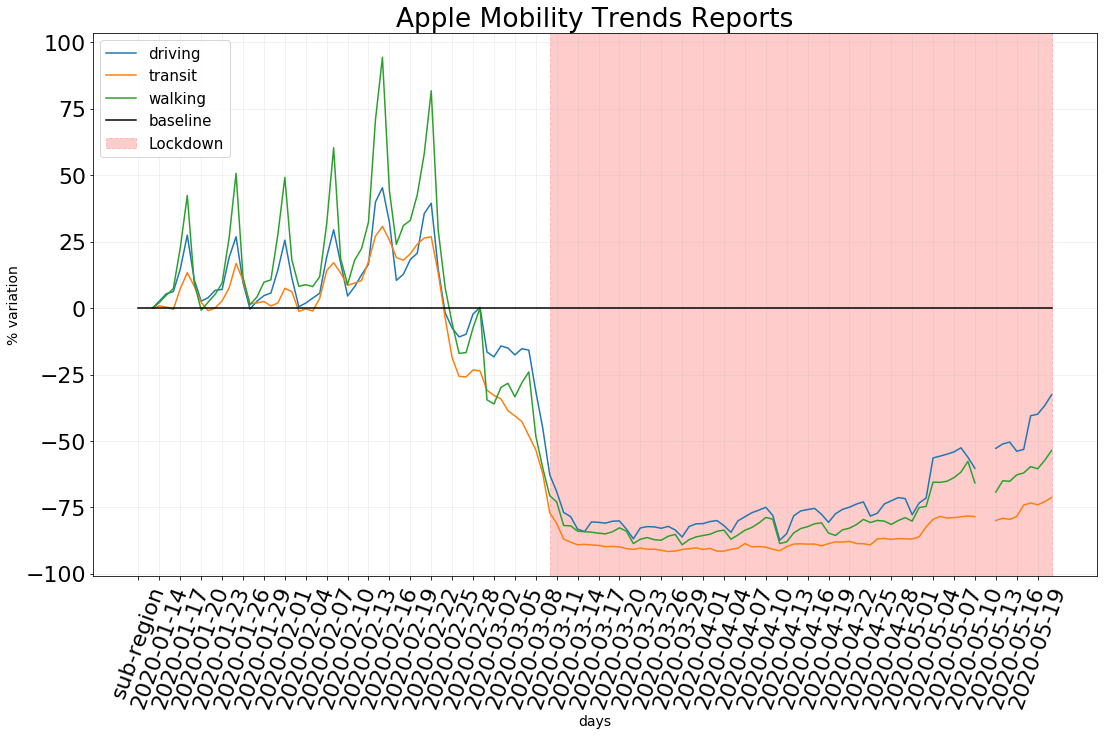

In [50]:
fig = plt.figure(figsize=(18,10))
plt.plot(dates, mobility['driving']-100, label = 'driving')
plt.plot(dates, mobility['transit']-100, label = 'transit')
plt.plot(dates, mobility['walking']-100, label = 'walking')
plt.plot(dates, np.zeros(mobility.shape[0]), label = 'baseline', c = 'black')
plt.axvspan(dates[lockdown_idx], dates[-1], label = 'Lockdown', color = 'r', alpha = 0.2, linestyle = '--')
plt.xticks(dates[0:-1:3], rotation = 70)

plt.title('Apple Mobility Trends Reports')
plt.ylabel('% variation', fontsize = 14)
plt.xlabel('days', fontsize = 14)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

In [51]:
mobility_pci = mobility.loc[dates[pci_idx:]]
mobility_pci

,driving,transit,walking
2020-02-24,98.2,96.25,107.66
2020-02-25,92.5,81.28,94.26
2020-02-26,89.15,74.29,82.94
2020-02-27,90.16,74.11,83.27
2020-02-28,97.78,76.73,92.59
...,...,...,...
2020-05-17,46.84,25.92,37.99
2020-05-18,59.52,26.67,40.36
2020-05-19,60.08,26,39.54
2020-05-20,63.26,27.17,42.65


In [52]:
pci_start = '2020-02-24'
pci_end = '2020-05-10'
pci_idx_start = np.argwhere(dates == pci_start).flatten()[0]
pci_idx_end = np.argwhere(dates == pci_end).flatten()[0]
mobility_pci = mobility.loc[dates[pci_idx_start:pci_idx_end]]
transit = mobility_pci['transit']

from sklearn import preprocessing
dataNorm=((transit-transit.min())/(transit.max()-transit.min()))*0.3+0.7
print(dataNorm)

2020-02-24           1
2020-02-25    0.948861
2020-02-26    0.924983
2020-02-27    0.924368
2020-02-28    0.933318
                ...   
2020-05-05    0.745092
2020-05-06     0.74294
2020-05-07    0.743555
2020-05-08     0.74458
2020-05-09    0.745639
Name: transit, Length: 76, dtype: object


In [53]:
FMT_M = '%d-%m-%Y'
start_date_M = '09-03-2020'
tmax_M = 90
tvec_M=np.arange(0,tmax_M,1)

date_M = list()
for i in range (0,tmax_M):
    date_M.append(datetime.strptime(start_date_M, FMT_M)+timedelta(days=i))

(0, 20000)

<Figure size 2880x864 with 0 Axes>

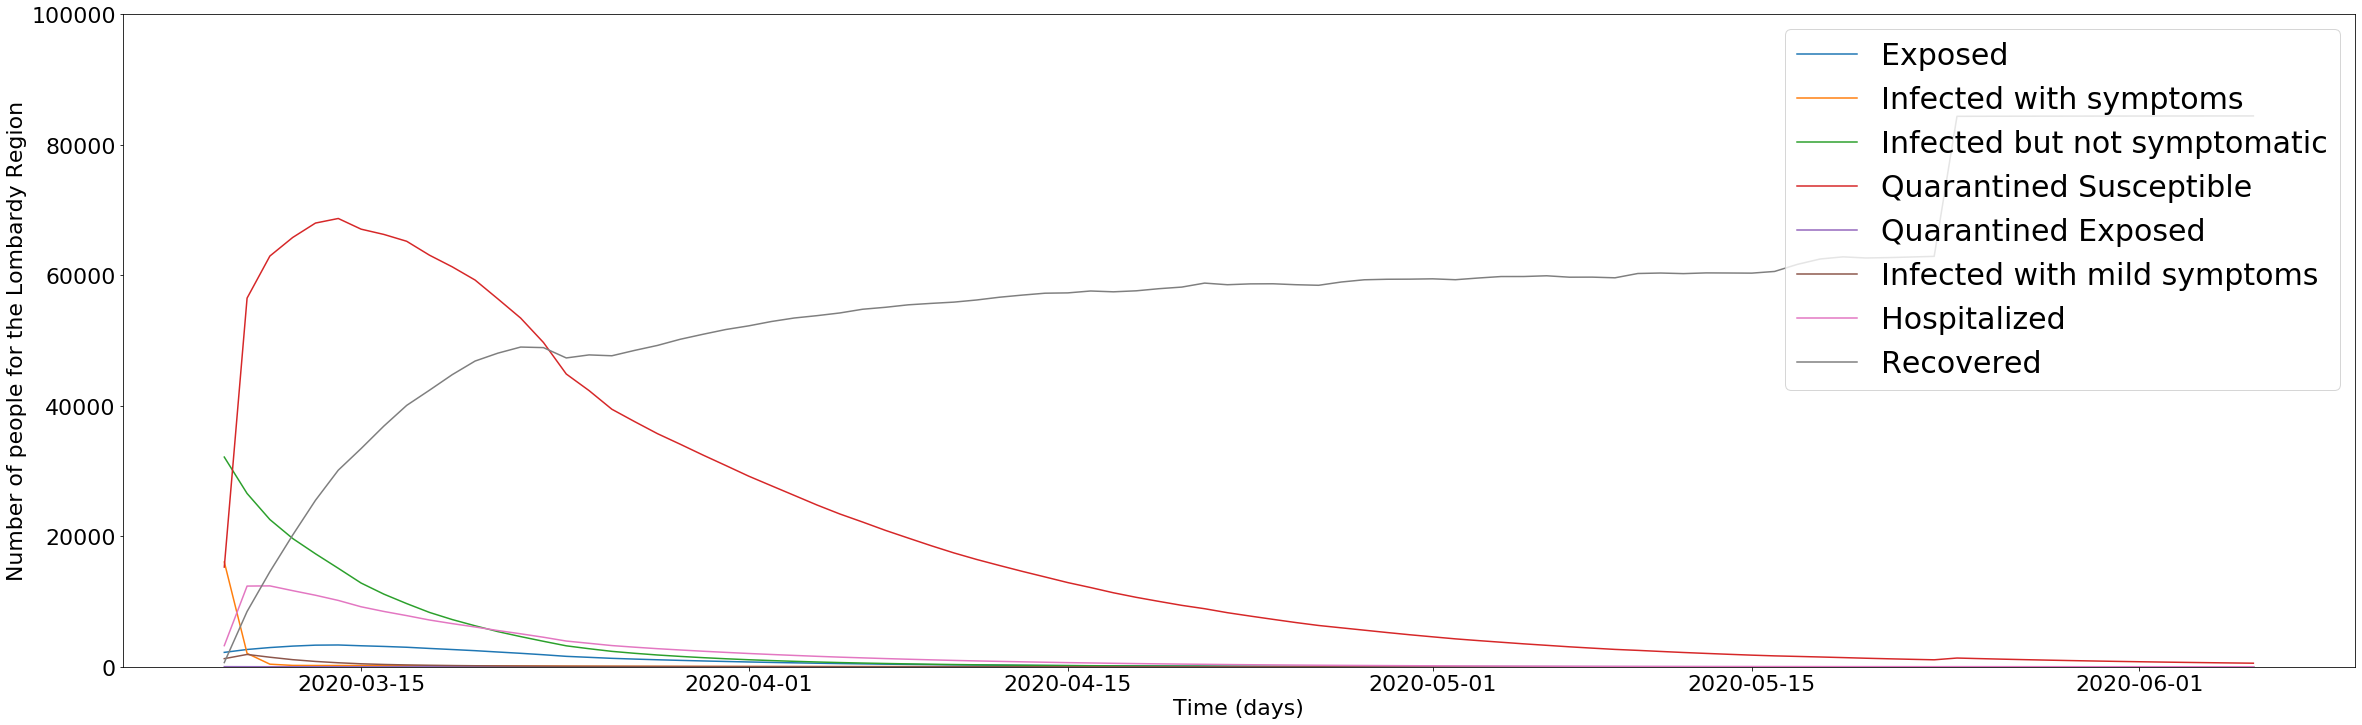

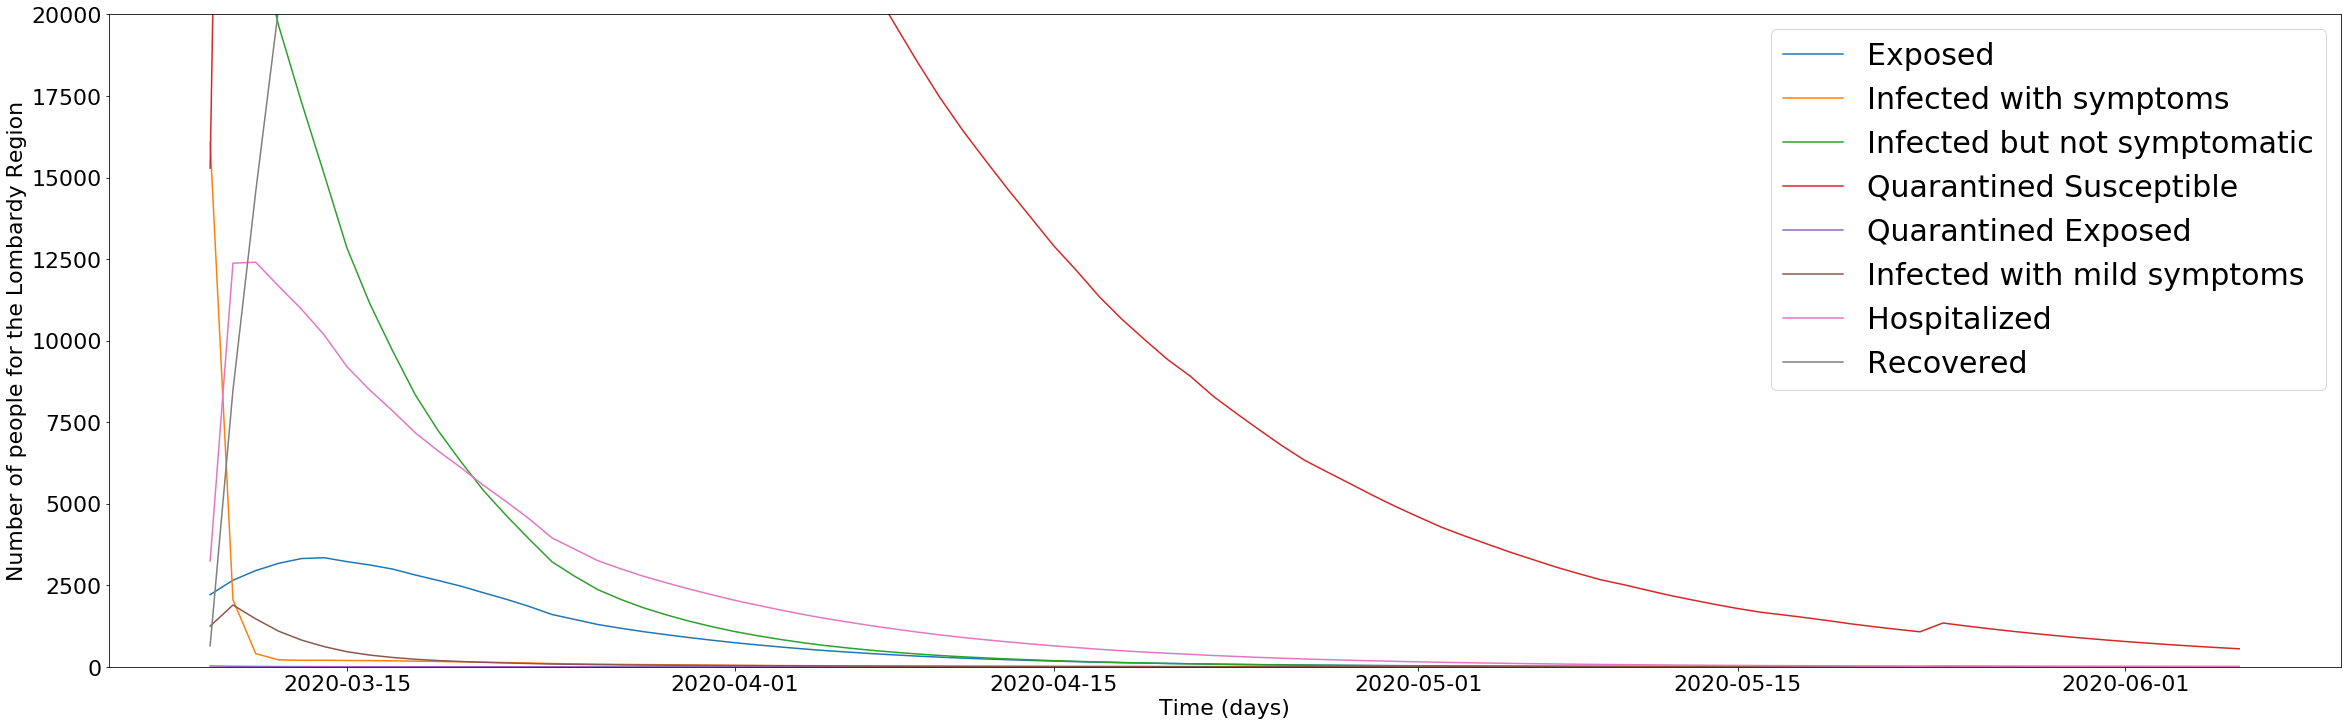

In [54]:
ic_L_M=np.zeros(8)
ic_L_M[0]=E_L
ic_L_M[1]=I_L
ic_L_M[2]=A_L
ic_L_M[3]=Sq_L
ic_L_M[4]=Eq_L
ic_L_M[5]=L_L
ic_L_M[6]=H_L
ic_L_M[7]=R_L

soln_L_M =odeint(SEIRpaper,ic_L_M,tvec_M,args=(c_L,delta_I_L,beta,q,sigma,l,rho,delta_q,gamma_I,gamma_A,gamma_H,alfa,theta,epsylon_I,epsylon_q,gamma_L,delta_L,N_L,D_L))
   
soln_L_M_new = np.zeros(shape=soln_L_M.shape)
for i,row in enumerate(soln_L_M):
    if i > (dataNorm.shape[0]-1):
        array = np.random.uniform(low=1, high=1,size=8)
        soln_L_M_new[i]=array*row
    else:
        array = np.random.uniform(low=dataNorm[i], high=dataNorm[i],size=8)
        soln_L_M_new[i]=array*row
    

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(40,12))

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(date_M,soln_L_M_new)
plt.xlabel("Time (days)")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered"], prop={"size":30},loc="upper right")
plt.ylim((0,100000))

plt.figure(figsize=(40,12))
#plt.subplot(1,2,2)
plt.plot(date_M,soln_L_M_new)
plt.xlabel("Time (days)")
plt.ylabel("Number of people for the Lombardy Region")
plt.legend(["Exposed","Infected with symptoms","Infected but not symptomatic","Quarantined Susceptible","Quarantined Exposed","Infected with mild symptoms","Hospitalized","Recovered"], prop={"size":30},loc="upper right")
plt.ylim((0,20000))

### Problemi:
1)Il primo problema riscontrato per tale approccio è circa le curve cumulabili che seguono il modello logistico (come ad es. il compartimento dei Recovered); in tal caso abbiamo notato che la curva tende ad abbassarsi per poi risalire, andamento anomalo dovuto ai pesi relativi alla mobilità.
<br>2)Il secondo problema è stato riscontrato per la normalizzazione, poichè normalizzando tra 0 ed 1 le curve venivano completamente 'abbattute' a causa dei valori prossimi a zero generati. Per questa motivazione abbiamo deciso di normalizzare in un intervallo meno ampio [0.7 - 1].

### Riscontro:
Da tali osservazioni possiamo confermare che tale approccio è utile solo per analizzare il trend delle curve, i cui valori a causa dei pesi vengono ridimensionati violando il vincolo di popolazione costante del modello SEIR esteso.

# APPENDICE

## Documento Sorgete Modello Cinese
![title](../data/Pag1-Cinese.png)
![title](../data/Pag2-Cinese.png)
![title](../data/Pag3-Cinese.png)
![title](../data/Pag4-Cinese.png)
![title](../data/Pag5-Cinese.png)
![title](../data/Pag6-Cinese.png)
![title](../data/Pag7-Cinese.png)
![title](../data/Pag8-Cinese.png)

# RIFERIMENTI BIBLIOGRAFICI MODELLO SEIR CINESE
References
Abbott, Sam. 2020. “Temporal Variation in Transmission During the COVID-19 Outbreak.” CMMID Repository. https://cmmid.github.io/topics/covid19/current-patterns-transmission/global-time-varying-transmission.html.

Ajao, Adebola, Scott V. Nystrom, Lisa M. Koonin, Anita Patel, David R. Howell, Prasith Baccam, Tim Lant, Eileen Malatino, Margaret Chamberlin, and Martin I. Meltzer. 2015. “Assessing the Capacity of the Healthcare System to Use Additional Mechanical Ventilators During a Large-Scale Public Health Emergency (PHE).” Disaster Medicine and Public Health Preparedness 9 (6): 634–41. https://doi.org/10.1017/dmp.2015.105.

Baud, David, Xiaolong Qi, Karin Nielsen-Saines, Didier Musso, Leo Pomar, and Guillaume Favre. 2020. “Real Estimates of Mortality Following COVID-19 Infection.” The Lancet Infectious Diseases 0 (0). https://doi.org/10.1016/S1473-3099(20)30195-X.

Bi, Qifang, Yongsheng Wu, Shujiang Mei, Chenfei Ye, Xuan Zou, Zhen Zhang, Xiaojian Liu, et al. 2020. “Epidemiology and Transmission of COVID-19 in Shenzhen China: Analysis of 391 Cases and 1,286 of Their Close Contacts.” medRxiv, March, 2020.03.03.20028423. https://doi.org/10.1101/2020.03.03.20028423.

Critical Care Medicine (SCCM), Society of. 2010. “SCCM Critical Care Statistics.” https://sccm.org/Communications/Critical-Care-Statistics.

Du, Zhanwei, Xiaoke Xu, Ye Wu, Lin Wang, Benjamin J. Cowling, and Lauren Ancel Meyers. 2020. “The Serial Interval of COVID-19 from Publicly Reported Confirmed Cases.” medRxiv, March, 2020.02.19.20025452. https://doi.org/10.1101/2020.02.19.20025452.

Ganyani, Tapiwa, Cecile Kremer, Dongxuan Chen, Andrea Torneri, Christel Faes, Jacco Wallinga, and Niel Hens. 2020. “Estimating the Generation Interval for COVID-19 Based on Symptom Onset Data.” medRxiv, March, 2020.03.05.20031815. https://doi.org/10.1101/2020.03.05.20031815.

Guan, Wei-jie, Zheng-yi Ni, Yu Hu, Wen-hua Liang, Chun-quan Ou, Jian-xing He, Lei Liu, et al. 2020. “Clinical Characteristics of Coronavirus Disease 2019 in China.” New England Journal of Medicine 0 (0): null. https://doi.org/10.1056/NEJMoa2002032.

Huang, Chaolin, Yeming Wang, Xingwang Li, Lili Ren, Jianping Zhao, Yi Hu, Li Zhang, et al. 2020. “Clinical Features of Patients Infected with 2019 Novel Coronavirus in Wuhan, China.” The Lancet 395 (10223): 497–506. https://doi.org/10.1016/S0140-6736(20)30183-5.

Lauer, Stephen A., Kyra H. Grantz, Qifang Bi, Forrest K. Jones, Qulu Zheng, Hannah Meredith, Andrew S. Azman, Nicholas G. Reich, and Justin Lessler. 2020. “The Incubation Period of 2019-nCoV from Publicly Reported Confirmed Cases: Estimation and Application.” medRxiv, February, 2020.02.02.20020016. https://doi.org/10.1101/2020.02.02.20020016.

Li, Qun, Xuhua Guan, Peng Wu, Xiaoye Wang, Lei Zhou, Yeqing Tong, Ruiqi Ren, et al. 2020. “Early Transmission Dynamics in Wuhan, China, of Novel Coronavirus-Infected Pneumonia.” New England Journal of Medicine 0 (0): null. https://doi.org/10.1056/NEJMoa2001316.

Linton, Natalie M., Tetsuro Kobayashi, Yichi Yang, Katsuma Hayashi, Andrei R. Akhmetzhanov, Sung-mok Jung, Baoyin Yuan, Ryo Kinoshita, and Hiroshi Nishiura. 2020. “Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data.” Journal of Clinical Medicine 9 (2): 538. https://doi.org/10.3390/jcm9020538.

Liu, Jingyuan, Yao Liu, Pan Xiang, Lin Pu, Haofeng Xiong, Chuansheng Li, Ming Zhang, et al. 2020. “Neutrophil-to-Lymphocyte Ratio Predicts Severe Illness Patients with 2019 Novel Coronavirus in the Early Stage.” medRxiv, February, 2020.02.10.20021584. https://doi.org/10.1101/2020.02.10.20021584.

Liu, Yang, Sebastian Funk, and Stefan Flasche. 2020. “The Contribution of Pre-Symptomatic Transmission to the COVID-19 Outbreak.” CMMID Repository. https://cmmid.github.io/topics/covid19/control-measures/pre-symptomatic-transmission.html.

Mizumoto, Kenji, Katsushi Kagaya, Alexander Zarebski, and Gerardo Chowell. 2020. “Estimating the Asymptomatic Ratio of 2019 Novel Coronavirus Onboard the Princess Cruises Ship, 2020.” medRxiv, February, 2020.02.20.20025866. https://doi.org/10.1101/2020.02.20.20025866.

National Center for Health Statistics. 2017. “Table 89. Hospitals, Beds, and Occupancy Rates, by Type of Ownership and Size of Hospital: United States, Selected Years 1975-2015.”

Nishiura, Hiroshi, Tetsuro Kobayashi, Takeshi Miyama, Ayako Suzuki, Sungmok Jung, Katsuma Hayashi, Ryo Kinoshita, et al. 2020. “Estimation of the Asymptomatic Ratio of Novel Coronavirus Infections (COVID-19).” medRxiv, February, 2020.02.03.20020248. https://doi.org/10.1101/2020.02.03.20020248.

Riou, Julien, Anthony Hauser, Michel J. Counotte, and Christian L. Althaus. 2020. “Adjusted Age-Specific Case Fatality Ratio During the COVID-19 Epidemic in Hubei, China, January and February 2020.” medRxiv, March. https://doi.org/10.1101/2020.03.04.20031104.

Russell, Timothy W. 2020. “Estimating the Infection and Case Fatality Ratio for COVID-19 Using Age-Adjusted Data from the Outbreak on the Diamond Princess Cruise Ship.” CMMID Repository. https://cmmid.github.io/topics/covid19/severity/diamond_cruise_cfr_estimates.html.

Sanche, Steven, Yen Ting Lin, Chonggang Xu, Ethan Romero-Severson, Nick Hengartner, and Ruian Ke. 2020. “The Novel Coronavirus, 2019-nCoV, Is Highly Contagious and More Infectious Than Initially Estimated.” medRxiv, February, 2020.02.07.20021154. https://doi.org/10.1101/2020.02.07.20021154.

Tindale, Lauren, Michelle Coombe, Jessica E. Stockdale, Emma Garlock, Wing Yin Venus Lau, Manu Saraswat, Yen-Hsiang Brian Lee, et al. 2020. “Transmission Interval Estimates Suggest Pre-Symptomatic Spread of COVID-19.” medRxiv, March, 2020.03.03.20029983. https://doi.org/10.1101/2020.03.03.20029983.

Verity, Robert, Lucy C. Okell, Ilaria Dorigatti, Peter Winskill, Charles Whittaker, Natsuko Imai, Gina Cuomo-Dannenburg, et al. 2020. “Estimates of the Severity of COVID-19 Disease.” medRxiv, March, 2020.03.09.20033357. https://doi.org/10.1101/2020.03.09.20033357.

Wang, Jiancong, Mouqing Zhou, and Fangfei Liu. 2020. “Exploring the Reasons for Healthcare Workers Infected with Novel Coronavirus Disease 2019 (COVID-19) in China.” Journal of Hospital Infection 0 (0). https://doi.org/10.1016/j.jhin.2020.03.002.

Woelfel, Roman, Victor Max Corman, Wolfgang Guggemos, Michael Seilmaier, Sabine Zange, Marcel A. Mueller, Daniela Niemeyer, et al. 2020. “Clinical Presentation and Virological Assessment of Hospitalized Cases of Coronavirus Disease 2019 in a Travel-Associated Transmission Cluster.” medRxiv, March, 2020.03.05.20030502. https://doi.org/10.1101/2020.03.05.20030502.

Wu, Joseph T., Kathy Leung, Mary Bushman, Nishant Kishore, Rene Niehus, Pablo M. de Salazar, Benjamin J. Cowling, Marc Lipsitch, and Gabriel M. Leung. 2020. “Estimating Clinical Severity of COVID-19 from the Transmission Dynamics in Wuhan, China.” Nature Medicine, March, 1–5. https://doi.org/10.1038/s41591-020-0822-7.

Wu, Zunyou, and Jennifer M. McGoogan. 2020. “Characteristics of and Important Lessons from the Coronavirus Disease 2019 (COVID-19) Outbreak in China: Summary of a Report of 72 314 Cases from the Chinese Center for Disease Control and Prevention.” JAMA, February. https://doi.org/10.1001/jama.2020.2648.

Yang, Penghui, Yibo Ding, Zhe Xu, Rui Pu, Ping Li, Jin Yan, Jiluo Liu, et al. 2020. “Epidemiological and Clinical Features of COVID-19 Patients with and Without Pneumonia in Beijing, China.” medRxiv, March, 2020.02.28.20028068. https://doi.org/10.1101/2020.02.28.20028068.

Yang, Xiaobo, Yuan Yu, Jiqian Xu, Huaqing Shu, Jia’an Xia, Hong Liu, Yongran Wu, et al. 2020. “Clinical Course and Outcomes of Critically Ill Patients with SARS-CoV-2 Pneumonia in Wuhan, China: A Single-Centered, Retrospective, Observational Study.” The Lancet Respiratory Medicine 0 (0). https://doi.org/10.1016/S2213-2600(20)30079-5.

Zhao, Qingyuan, Yang Chen, and Dylan S. Small. 2020. “Analysis of the Epidemic Growth of the Early 2019-nCoV Outbreak Using Internationally Confirmed Cases.” medRxiv, February, 2020.02.06.20020941. https://doi.org/10.1101/2020.02.06.20020941.

Zhou, Fei, Ting Yu, Ronghui Du, Guohui Fan, Ying Liu, Zhibo Liu, Jie Xiang, et al. 2020. “Clinical Course and Risk Factors for Mortality of Adult Inpatients with COVID-19 in Wuhan, China: A Retrospective Cohort Study.” The Lancet 0 (0). https://doi.org/10.1016/S0140-6736(20)30566-3.